# Google Tunix Hackathon — Train Gemma 3 1B IT to **show its work** (SFT → GRPO) ✅

This notebook is a **config-driven**, reproducible, TPU-friendly training pipeline that:
- Loads **Gemma 3 1B IT** from Kaggle input
- Applies **LoRA** adapters (parameter-efficient finetuning)
- Runs **Stage 1: SFT** to “lock in” the required XML output format
- Runs **Stage 2: GRPO (RL)** with a composite reward (format + answer + reasoning quality)
- Saves **Orbax checkpoints** (for Tunix re-loading) and optionally exports a merged HF model for local inference demos

It is designed to follow the *Kaggle Tunix Hackathon notebook submission template* patterns, with:
- Clear sections (data, hyperparams, prompt, training strategy)
- Checkpointing for reproducibility
- Default hyperparameters small enough to **smoke test** the full pipeline end-to-end (edit `config.yaml` to scale up)

> **Note about GRPO “taking a long time” at the start:** the first call compiles large JAX graphs.  
> **10–20 minutes of “no visible progress” can be normal** on the first GRPO step; later steps run much faster.


## Submission modes (important)

This notebook supports both hackathon evaluation modes:

- **Single-session mode (45 pts):** start from the stock Gemma model and finish training in **one** TPU session.  
  Do **not** load external checkpoints. The judges will rerun the notebook and evaluate the **last checkpoint**.

- **Unrestricted / multi-session mode (optional +15 pts):** you can resume from checkpoints across sessions, *but you must provide a Kaggle model ID* at the end of the notebook so judges can load it.

You control the mode via `config.yaml` (`submission.mode`).


In [1]:
print('test')

test


In [2]:
# =========================
# 0) Configuration (config.yaml) — FIXED (handles null unrestricted_kaggle_model_id)
# =========================
# All tunables live in config.yaml. This notebook reads them and assigns variables.
# If config.yaml doesn't exist, we write a small "smoke test" config you can edit.

from __future__ import annotations

from pathlib import Path
from typing import Optional, Literal, List, Dict, Any
import os

# YAML loader
try:
    import yaml  # PyYAML
except Exception as e:
    raise RuntimeError(
        "Missing dependency: pyyaml. Install it with `pip install pyyaml` and re-run."
    ) from e

# Pydantic config models (recommended for validation)
try:
    from pydantic import BaseModel, Field, field_validator
except Exception as e:
    raise RuntimeError(
        "Missing dependency: pydantic. Install it with `pip install pydantic` and re-run."
    ) from e


DEFAULT_CONFIG_YAML = """
model:
  family: gemma3
  id: google/gemma-3-1b-it
  # If null, we auto-search under /kaggle/input
  local_dir: null
  # Used only when auto-searching; a substring that should appear in the model path
  prefer: gemma-3-1b-it
  dtype: bfloat16
  rank: 64
  alpha: 64.0
  lora_module_path: ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|.*attn_vec_einsum"
  eos_tokens: [1, 106]

data:
  # If null, we auto-search under /kaggle/input for common train files (train.csv/train.parquet)
  train_path: null
  # Optional: if null we split from train
  eval_path: null
  val_frac: 0.02
  seed: 123
  max_train_rows: 5000
  max_eval_rows: 500
  q_col: null
  a_col: null
  r_col: null
  id_col: null
  system_prompt: |
    You are a helpful assistant that must produce:
    <reasoning> ... </reasoning>
    <answer> ... </answer>
    
    Rules:
    - Put ALL your reasoning inside <reasoning>...</reasoning>.
    - Put ONLY the final answer inside <answer>...</answer>.
    - Output exactly two top-level XML tags: <reasoning> and <answer>.
  template: "{system_prompt}\n\nQuestion: {question}\n\nAnswer: "

sft:
  enabled: true
  max_seq_len: 512
  global_batch_size: 64
  # learning rate scaling:
  #   lr = lr_ref_global * global_batch_size / lr_ref_batch
  lr_ref_global: 2.0e-5
  lr_ref_batch: 64
  max_steps: 50
  eval_every_steps: 25
  weight_decay: 0.05
  b1: 0.9
  b2: 0.99
  max_examples: 4000

grpo:
  enabled: true
  # Keep these small for pipeline validation
  max_prompt_length: 256
  total_generation_steps: 128
  safety_max_prompt_length: 512
  safety_max_generation_steps: 256
  temperature: 0.9
  top_p: 1.0
  top_k: 50
  num_generations: 8
  num_iterations: 1
  beta: 0.04
  epsilon: 0.2
  max_steps: 300
  eval_every_steps: 50
  warmup_steps: 30
  learning_rate: 5.0e-6
  b1: 0.9
  b2: 0.95
  weight_decay: 0.05
  max_grad_norm: 1.0
  train_micro_batch_size: 4
  rollout_micro_batch_pref: 1
  compute_logps_micro_batch_pref: 1
  offload_to_cpu: false
  kv_cache_extra: 256
  max_train_examples: 2000
  max_eval_examples: 200

export:
  enabled: true
  export_root: "/kaggle/working/export"
  run_name: "google_gemma-3-1b-it_tunix_sft_grpo"
  merged_subdir: "merged_lora"
  save_after_sft: true
  save_after_grpo: true
  save_interval_steps: 100
  max_to_keep: 2

inference:
  enabled: true
  # If set, load this directory for inference (e.g. exported merged_lora).
  # If null, falls back to the merged LoRA export for this run.
  model_dir: null
  max_new_tokens: 256
  do_sample: true
  temperature: 0.7
  top_p: 0.95
  top_k: 50
  num_beams: 1
  repetition_penalty: 1.0
  batch_size: 1
  max_examples: 16
  output_csv: "/kaggle/working/predictions.csv"

runtime:
  require_tpu: true
  mesh_fsdp: 8
  mesh_tp: 1
  skip_training_if_export_exists: true
  force_retrain: false
  silence_asyncio_noise: true

submission:
  mode: single_session   # single_session | unrestricted
  unrestricted_kaggle_model_id: """""


class ModelCfg(BaseModel):
    family: Literal["gemma3", "gemma2"] = "gemma3"
    id: str = "google/gemma-3-1b-it"
    local_dir: Optional[str] = None
    prefer: Optional[str] = "gemma-3-1b-it"
    dtype: Literal["bfloat16", "float16", "float32"] = "bfloat16"
    rank: int = 64
    alpha: float = 64.0
    lora_module_path: str = ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|.*attn_vec_einsum"
    eos_tokens: List[int] = Field(default_factory=lambda: [1, 106])


class DataCfg(BaseModel):
    train_path: Optional[str] = None
    eval_path: Optional[str] = None
    val_frac: float = 0.02
    seed: int = 123
    max_train_rows: int = 5000
    max_eval_rows: int = 500
    q_col: Optional[str] = None
    a_col: Optional[str] = None
    r_col: Optional[str] = None
    id_col: Optional[str] = None
    system_prompt: str = "You are a helpful assistant."
    template: str = "{system_prompt}\n\nQuestion: {question}\n\nAnswer: "


class SFTCfg(BaseModel):
    enabled: bool = True
    max_seq_len: int = 512
    global_batch_size: int = 64
    lr_ref_global: float = 2.0e-5
    lr_ref_batch: int = 64
    max_steps: int = 50
    eval_every_steps: int = 25
    weight_decay: float = 0.05
    b1: float = 0.9
    b2: float = 0.99
    max_examples: int = 4000

    def learning_rate(self) -> float:
        return float(self.lr_ref_global) * float(self.global_batch_size) / float(self.lr_ref_batch)


class GRPOCfg(BaseModel):
    enabled: bool = True
    max_prompt_length: int = 256
    total_generation_steps: int = 128
    safety_max_prompt_length: int = 512
    safety_max_generation_steps: int = 256
    temperature: float = 0.9
    top_p: float = 1.0
    top_k: int = 50
    num_generations: int = 8
    num_iterations: int = 1
    beta: float = 0.04
    epsilon: float = 0.2
    max_steps: int = 300
    eval_every_steps: int = 50
    warmup_steps: int = 30
    learning_rate: float = 5.0e-6
    b1: float = 0.9
    b2: float = 0.95
    weight_decay: float = 0.05
    max_grad_norm: Optional[float] = 1.0
    train_micro_batch_size: int = 4
    rollout_micro_batch_pref: int = 1
    compute_logps_micro_batch_pref: int = 1
    offload_to_cpu: bool = False
    kv_cache_extra: int = 256
    max_train_examples: int = 2000
    max_eval_examples: int = 200


class ExportCfg(BaseModel):
    enabled: bool = True
    export_root: str = "/kaggle/working/export"
    run_name: str = "google_gemma-3-1b-it_tunix_sft_grpo"
    merged_subdir: str = "merged_lora"
    save_after_sft: bool = True
    save_after_grpo: bool = True
    save_interval_steps: int = 100
    max_to_keep: int = 2


class InferenceCfg(BaseModel):
    enabled: bool = True
    model_dir: Optional[str] = None
    max_new_tokens: int = 256
    do_sample: bool = True
    temperature: float = 0.7
    top_p: float = 0.95
    top_k: int = 50
    num_beams: int = 1
    repetition_penalty: float = 1.0
    batch_size: int = 1
    max_examples: int = 16
    output_csv: str = "/kaggle/working/predictions.csv"


class RuntimeCfg(BaseModel):
    require_tpu: bool = True
    mesh_fsdp: int = 8
    mesh_tp: int = 1
    skip_training_if_export_exists: bool = True
    force_retrain: bool = False
    silence_asyncio_noise: bool = True


class SubmissionCfg(BaseModel):
    mode: Literal["single_session", "unrestricted"] = "single_session"
    unrestricted_kaggle_model_id: Optional[str] = ""

    @field_validator("unrestricted_kaggle_model_id", mode="before")
    @classmethod
    def _none_to_empty(cls, v):
        # Accept null/None in YAML and convert to empty string
        return "" if v is None else str(v)


class NotebookCfg(BaseModel):
    model: ModelCfg = Field(default_factory=ModelCfg)
    data: DataCfg = Field(default_factory=DataCfg)
    sft: SFTCfg = Field(default_factory=SFTCfg)
    grpo: GRPOCfg = Field(default_factory=GRPOCfg)
    export: ExportCfg = Field(default_factory=ExportCfg)
    inference: InferenceCfg = Field(default_factory=InferenceCfg)
    runtime: RuntimeCfg = Field(default_factory=RuntimeCfg)
    submission: SubmissionCfg = Field(default_factory=SubmissionCfg)


CONFIG_PATH = Path("config.yaml")

if not CONFIG_PATH.exists():
    CONFIG_PATH.write_text(DEFAULT_CONFIG_YAML.strip() + "\n", encoding="utf-8")
    print(f"✅ Wrote default config.yaml to: {CONFIG_PATH.resolve()}")
    print("   Edit it (especially data.train_path / model.local_dir) and re-run this cell if needed.")

cfg_dict = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8")) or {}

# --- Pydantic safety: allow null in YAML for strings (common when editing config.yaml)
# Kaggle templates sometimes use null for optional fields; we coerce to empty string.
try:
    if isinstance(cfg_dict, dict):
        sub = cfg_dict.get("submission") or {}
        if sub.get("unrestricted_kaggle_model_id", "") is None:
            sub["unrestricted_kaggle_model_id"] = ""
        cfg_dict["submission"] = sub
except Exception:
    pass

cfg = NotebookCfg.model_validate(cfg_dict)

print("✅ Loaded config.yaml")
print("  model:", cfg.model.family, "|", cfg.model.id, "| rank:", cfg.model.rank)
print("  data: train_path:", cfg.data.train_path, "| val_frac:", cfg.data.val_frac)
print("  sft: enabled:", cfg.sft.enabled, "| steps:", cfg.sft.max_steps, "| lr:", cfg.sft.learning_rate())
print("  grpo: enabled:", cfg.grpo.enabled, "| steps:", cfg.grpo.max_steps, "| G:", cfg.grpo.num_generations)
print("  export:", cfg.export.export_root, "/", cfg.export.run_name, "/", cfg.export.merged_subdir)
print("  submission:", cfg.submission.mode, "| kaggle_model_id:", cfg.submission.unrestricted_kaggle_model_id or "(empty)")

✅ Wrote default config.yaml to: /kaggle/working/config.yaml
   Edit it (especially data.train_path / model.local_dir) and re-run this cell if needed.
✅ Loaded config.yaml
  model: gemma3 | google/gemma-3-1b-it | rank: 64
  data: train_path: None | val_frac: 0.02
  sft: enabled: True | steps: 50 | lr: 2e-05
  grpo: enabled: True | steps: 300 | G: 8
  export: /kaggle/working/export / google_gemma-3-1b-it_tunix_sft_grpo / merged_lora
  submission: single_session | kaggle_model_id: (empty)


In [3]:

# =========================
# 1) Assign notebook variables from cfg (compat layer)
# =========================
from pathlib import Path

# Paths
KAGGLE_INPUT = Path("/kaggle/input")
KAGGLE_WORKING = Path("/kaggle/working")

RUN_NAME = cfg.export.run_name

EXPORT_ROOT = Path(cfg.export.export_root)
RUN_EXPORT_DIR = EXPORT_ROOT / RUN_NAME
MERGED_LORA_DIR = RUN_EXPORT_DIR / cfg.export.merged_subdir

TB_DIR = KAGGLE_WORKING / "tensorboard" / RUN_NAME
CKPT_DIR = KAGGLE_WORKING / "checkpoints" / RUN_NAME

for p in [TB_DIR, CKPT_DIR, RUN_EXPORT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Model
MODEL_FAMILY = cfg.model.family
MODEL_ID = cfg.model.id
RANK = int(cfg.model.rank)
ALPHA = float(cfg.model.alpha)
LORA_MODULE_PATH = cfg.model.lora_module_path
DTYPE_STR = cfg.model.dtype

# Data
VAL_FRAC = float(cfg.data.val_frac)
q_col = cfg.data.q_col
a_col = cfg.data.a_col
r_col = cfg.data.r_col
id_col = cfg.data.id_col
SYSTEM_PROMPT = cfg.data.system_prompt
TEMPLATE = cfg.data.template

# =========================
# Submission-template compatible prompt (PROMPT_TEMPLATE expects only {question})
# =========================
# Our config template may include {system_prompt}. We “freeze” it here so later code can call:
#   PROMPT_TEMPLATE.format(question="...")
PROMPT_TEMPLATE = TEMPLATE.format(system_prompt=SYSTEM_PROMPT, question="{question}")

# Backwards-compatible helper
def build_prompt(question: str) -> str:
    return PROMPT_TEMPLATE.format(question=str(question))

# =========================
# Required XML tags + regex helpers (used by rewards + eval)
# =========================
import re

REQUIRED_TAGS = ["<reasoning>", "</reasoning>", "<answer>", "</answer>"]
EXTRACT_COT_RESPONSE_REGEX = re.compile(r"<reasoning>\s*(.*?)\s*</reasoning>", re.DOTALL)
EXTRACT_ANSWER_RESPONSE_REGEX = re.compile(r"<answer>\s*(.*?)\s*</answer>", re.DOTALL)
FINAL_RESPONSE_REGEX = EXTRACT_ANSWER_RESPONSE_REGEX


# SFT
RUN_SFT = bool(cfg.sft.enabled)
SFT_MAX_SEQ_LEN = int(cfg.sft.max_seq_len)
SFT_GLOBAL_BATCH_SIZE = int(cfg.sft.global_batch_size)
SFT_LEARNING_RATE = float(cfg.sft.learning_rate())
SFT_MAX_STEPS = int(cfg.sft.max_steps)
SFT_EVAL_EVERY = int(cfg.sft.eval_every_steps)
SFT_WEIGHT_DECAY = float(cfg.sft.weight_decay)
SFT_B1 = float(cfg.sft.b1)
SFT_B2 = float(cfg.sft.b2)
SFT_MAX_EXAMPLES = int(cfg.sft.max_examples)

# GRPO
RUN_GRPO = bool(cfg.grpo.enabled)
MAX_PROMPT_LENGTH = int(cfg.grpo.max_prompt_length)
TOTAL_GENERATION_STEPS = int(cfg.grpo.total_generation_steps)
TEMPERATURE = float(cfg.grpo.temperature)
TOP_P = float(cfg.grpo.top_p)
TOP_K = int(cfg.grpo.top_k)
NUM_GENERATIONS = int(cfg.grpo.num_generations)
NUM_ITERATIONS = int(cfg.grpo.num_iterations)
BETA = float(cfg.grpo.beta)
EPSILON = float(cfg.grpo.epsilon)

MAX_STEPS = int(cfg.grpo.max_steps)
EVAL_EVERY_N_STEPS = int(cfg.grpo.eval_every_steps)
WARMUP_STEPS = int(cfg.grpo.warmup_steps)
LEARNING_RATE = float(cfg.grpo.learning_rate)
B1 = float(cfg.grpo.b1)
B2 = float(cfg.grpo.b2)
WEIGHT_DECAY = float(cfg.grpo.weight_decay)
MAX_GRAD_NORM = cfg.grpo.max_grad_norm

TRAIN_MICRO_BATCH_SIZE = int(cfg.grpo.train_micro_batch_size)
ROLLOUT_MB_PREF = int(cfg.grpo.rollout_micro_batch_pref)
LOGPS_MB_PREF = int(cfg.grpo.compute_logps_micro_batch_pref)
OFFLOAD_TO_CPU = bool(cfg.grpo.offload_to_cpu)

SAFE_KV_CACHE_EXTRA = int(cfg.grpo.kv_cache_extra)
GRPO_SAFETY_MAX_PROMPT_LENGTH = int(cfg.grpo.safety_max_prompt_length)
GRPO_SAFETY_MAX_GEN_STEPS = int(cfg.grpo.safety_max_generation_steps)

GRPO_MAX_TRAIN_EXAMPLES = int(cfg.grpo.max_train_examples)
GRPO_MAX_EVAL_EXAMPLES = int(cfg.grpo.max_eval_examples)

# Runtime
REQUIRE_TPU = bool(cfg.runtime.require_tpu)
MESH_FSDP = int(cfg.runtime.mesh_fsdp)
MESH_TP = int(cfg.runtime.mesh_tp)
SKIP_IF_EXPORT_EXISTS = bool(cfg.runtime.skip_training_if_export_exists)
FORCE_RETRAIN = bool(cfg.runtime.force_retrain)
SILENCE_ASYNCIO_NOISE = bool(cfg.runtime.silence_asyncio_noise)

# Inference
RUN_INFERENCE = bool(cfg.inference.enabled)
INFER_DIR = Path(cfg.inference.model_dir) if cfg.inference.model_dir else MERGED_LORA_DIR
INFER_MAX_NEW_TOKENS = int(cfg.inference.max_new_tokens)
INFER_DO_SAMPLE = bool(cfg.inference.do_sample)
INFER_TEMPERATURE = float(cfg.inference.temperature)
INFER_TOP_P = float(cfg.inference.top_p)
INFER_TOP_K = int(cfg.inference.top_k)
INFER_NUM_BEAMS = int(cfg.inference.num_beams)
INFER_REPETITION_PENALTY = float(cfg.inference.repetition_penalty)
INFER_BATCH_SIZE = int(cfg.inference.batch_size)
INFER_MAX_EXAMPLES = int(cfg.inference.max_examples)
INFER_OUTPUT_CSV = str(cfg.inference.output_csv)


print("✅ Variables assigned from config.yaml via Pydantic.")


✅ Variables assigned from config.yaml via Pydantic.


In [4]:

# =========================
# 2) Print configuration summary (for reproducibility)
# =========================
import json
from pprint import pprint

print("=== Run Identifiers ===")
print("RUN_NAME:", RUN_NAME)
print("EXPORT_DIR:", RUN_EXPORT_DIR)
print("MERGED_LORA_DIR:", MERGED_LORA_DIR)
print("TB_DIR:", TB_DIR)
print("CKPT_DIR:", CKPT_DIR)

print("\n=== Model ===")
print("MODEL_FAMILY:", MODEL_FAMILY)
print("MODEL_ID:", MODEL_ID)
print("DTYPE:", DTYPE_STR)
print("LoRA rank/alpha:", RANK, "/", ALPHA)
print("LoRA module_path:", LORA_MODULE_PATH)

print("\n=== Data ===")
print("VAL_FRAC:", VAL_FRAC)
print("q_col/a_col/r_col/id_col:", q_col, a_col, r_col, id_col)
print("Max rows (train/eval):", cfg.data.max_train_rows, "/", cfg.data.max_eval_rows)

print("\n=== SFT ===")
print("RUN_SFT:", RUN_SFT)
print("SFT_MAX_SEQ_LEN:", SFT_MAX_SEQ_LEN)
print("SFT_GLOBAL_BATCH_SIZE:", SFT_GLOBAL_BATCH_SIZE)
print("SFT_LEARNING_RATE:", SFT_LEARNING_RATE)
print("SFT_MAX_STEPS:", SFT_MAX_STEPS)
print("SFT_EVAL_EVERY:", SFT_EVAL_EVERY)
print("SFT_MAX_EXAMPLES:", SFT_MAX_EXAMPLES)

print("\n=== GRPO ===")
print("RUN_GRPO:", RUN_GRPO)
print("MAX_PROMPT_LENGTH:", MAX_PROMPT_LENGTH)
print("GRPO_SAFETY_MAX_PROMPT_LENGTH:", GRPO_SAFETY_MAX_PROMPT_LENGTH)
print("TOTAL_GENERATION_STEPS:", TOTAL_GENERATION_STEPS)
print("GRPO_SAFETY_MAX_GEN_STEPS:", GRPO_SAFETY_MAX_GEN_STEPS)
print("TEMPERATURE/TOP_P/TOP_K:", TEMPERATURE, TOP_P, TOP_K)
print("NUM_GENERATIONS (G):", NUM_GENERATIONS)
print("NUM_ITERATIONS (μ):", NUM_ITERATIONS)
print("BETA/EPSILON:", BETA, EPSILON)
print("MAX_STEPS:", MAX_STEPS)
print("EVAL_EVERY_N_STEPS:", EVAL_EVERY_N_STEPS)
print("TRAIN_MICRO_BATCH_SIZE:", TRAIN_MICRO_BATCH_SIZE)
print("ROLLOUT_MB_PREF / LOGPS_MB_PREF:", ROLLOUT_MB_PREF, "/", LOGPS_MB_PREF)
print("OFFLOAD_TO_CPU:", OFFLOAD_TO_CPU)

print("\n=== Inference ===")
print("RUN_INFERENCE:", RUN_INFERENCE)
print("INFER_DIR:", INFER_DIR)
print("INFER_MAX_NEW_TOKENS:", INFER_MAX_NEW_TOKENS)
print("INFER_DO_SAMPLE:", INFER_DO_SAMPLE)

print("\n=== Full config (dict) ===")
pprint(cfg.model_dump())


=== Run Identifiers ===
RUN_NAME: google_gemma-3-1b-it_tunix_sft_grpo
EXPORT_DIR: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo
MERGED_LORA_DIR: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
TB_DIR: /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo
CKPT_DIR: /kaggle/working/checkpoints/google_gemma-3-1b-it_tunix_sft_grpo

=== Model ===
MODEL_FAMILY: gemma3
MODEL_ID: google/gemma-3-1b-it
DTYPE: bfloat16
LoRA rank/alpha: 64 / 64.0
LoRA module_path: .*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|.*attn_vec_einsum

=== Data ===
VAL_FRAC: 0.02
q_col/a_col/r_col/id_col: None None None None
Max rows (train/eval): 5000 / 500

=== SFT ===
RUN_SFT: True
SFT_MAX_SEQ_LEN: 512
SFT_GLOBAL_BATCH_SIZE: 64
SFT_LEARNING_RATE: 2e-05
SFT_MAX_STEPS: 50
SFT_EVAL_EVERY: 25
SFT_MAX_EXAMPLES: 4000

=== GRPO ===
RUN_GRPO: True
MAX_PROMPT_LENGTH: 256
GRPO_SAFETY_MAX_PROMPT_LENGTH: 512
TOTAL_GENERATION_STEPS: 128
GRPO_SAFETY_MAX_GEN_STEPS: 256
TEMPERAT

In [5]:

# =========================
# 3) Runtime setup (versions, seeding, logging)
# =========================
import os
import random
import numpy as np

# Reduce noisy logs (esp. ipykernel asyncio)
import logging
import warnings

if SILENCE_ASYNCIO_NOISE:
    logging.getLogger("asyncio").setLevel(logging.CRITICAL)
    warnings.filterwarnings("ignore", message=r".*coroutine.*was never awaited.*")
    warnings.filterwarnings("ignore", message=r".*Task was destroyed but it is pending.*")

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    try:
        import jax
        jax.random.PRNGKey(seed)  # warms JAX RNG
    except Exception:
        pass

seed_everything(cfg.data.seed)

import jax
import jax.numpy as jnp

print("Python:", os.sys.version)
print("JAX:", jax.__version__)
print("Backend:", jax.default_backend())
print("Devices:", len(jax.devices()), jax.devices()[:1])

if REQUIRE_TPU and jax.default_backend() != "tpu":
    raise RuntimeError(
        "This run requires TPU, but JAX backend is not TPU. "
        "Enable TPU VM in Kaggle Notebook Settings, then restart the session."
    )

def show_hbm_usage() -> None:
    """Best-effort per-device memory report (works on TPU in most Kaggle images)."""
    for d in jax.devices():
        try:
            stats = d.memory_stats()
            used = stats.get("bytes_in_use", 0) / (1024**3)
            limit = stats.get("bytes_limit", 0) / (1024**3)
            print(f"{d}: {used:.2f} GiB / {limit:.2f} GiB ({(used/limit*100) if limit else 0:.1f}%)")
        except Exception:
            print(f"{d}: memory_stats() unavailable")


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
E0000 00:00:1767115397.955078      12 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:238


Python: 3.12.12 (main, Dec  9 2025, 02:04:51) [GCC 14.2.0]
JAX: 0.8.1
Backend: tpu
Devices: 8 [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]


In [ ]:

# =========================
# (Optional) IPython display helpers
# =========================
from IPython.display import display


In [7]:

# =========================
# 3.1) Dependency check (expected in Kaggle TPU images where Tunix is preinstalled)
# =========================
import importlib

required_modules = [
    "tunix",
    "qwix",
    "grain",
    "orbax.checkpoint",
    "transformers",
]
missing = []
for m in required_modules:
    try:
        importlib.import_module(m)
    except Exception:
        missing.append(m)

if missing:
    raise RuntimeError(
        "Missing required Python packages: "
        + ", ".join(missing)
        + "\nIf you're on Kaggle with internet enabled, install with:\n"
        + "  pip install -q google-tunix[prod]==0.1.3 qwix grain orbax-checkpoint transformers\n"
    )

print("✅ Dependencies look available.")


✅ Dependencies look available.


In [8]:

# =========================
# 4) Create TPU mesh (AUTO axis types) — matches Tunix demo expectations
# =========================
from jax.sharding import AxisType

assert len(jax.devices()) >= (MESH_FSDP * MESH_TP), (
    f"Need at least {MESH_FSDP*MESH_TP} devices for mesh, found {len(jax.devices())}."
)

if hasattr(jax, "make_mesh"):
    mesh = jax.make_mesh(
        (MESH_FSDP, MESH_TP),
        ("fsdp", "tp"),
        axis_types=(AxisType.Auto, AxisType.Auto),
    )
else:
    # Fallback: older JAX (axis_types may not be supported; if you hit sharding issues, upgrade JAX)
    from jax.experimental import mesh_utils
    from jax.sharding import Mesh
    mesh = Mesh(mesh_utils.create_device_mesh((MESH_FSDP, MESH_TP)), ("fsdp", "tp"))

print("✅ Mesh:", mesh)


✅ Mesh: Mesh('fsdp': 8, 'tp': 1, axis_types=(Auto, Auto))


## Data loading and preparation

**Why GSM8K-style data for a reasoning hackathon?** For fast, reproducible progress in a single Kaggle TPU session, we want tasks where (a) the *final answer* is checkable and (b) a *step-by-step trace* is naturally expected. Grade-school math QA (GSM8K-style) is ideal for that:

- **Verifiable outcomes**: we can compute an accuracy reward from the final answer (numeric match).
- **Natural “show your work” traces**: the model is encouraged to lay out intermediate steps.
- **Compute efficient**: short prompts and manageable targets allow many RL rollouts per hour.

We use this dataset primarily to teach **format + reasoning habit** (XML compliance + coherent trace). The hackathon’s private evaluation covers broader domains; the intent here is to build a general *reasoning-capable* model within Kaggle constraints.

This notebook auto-detects common Kaggle inputs under `/kaggle/input` and infers schema (`q_col`, `a_col`, `id_col`) when not specified in `config.yaml`.


In [9]:

# =========================
# 5) Locate + load training data (CSV/Parquet)
# =========================
from pathlib import Path
import pandas as pd

def find_first_file(root: Path, patterns: list[str]) -> Path | None:
    root = Path(root)
    for pat in patterns:
        hits = sorted(root.rglob(pat))
        if hits:
            return hits[0]
    return None

def load_table(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Dataset file not found: {path}")
    if path.suffix.lower() == ".csv":
        return pd.read_csv(path)
    if path.suffix.lower() in [".parquet", ".pq"]:
        return pd.read_parquet(path)
    raise ValueError(f"Unsupported file type: {path.suffix} (use CSV or Parquet)")

# Pick train/eval paths
train_path = Path(cfg.data.train_path) if cfg.data.train_path else None
eval_path  = Path(cfg.data.eval_path)  if cfg.data.eval_path  else None

if train_path is None:
    # Auto-search common patterns in Kaggle inputs
    train_path = find_first_file(
        KAGGLE_INPUT,
        patterns=[
            "**/train.csv",
            "**/train.parquet",
            "**/training.csv",
            "**/training.parquet",
            "**/*train*.csv",
            "**/*train*.parquet",
        ],
    )

if train_path is None:
    raise FileNotFoundError(
        "Could not auto-locate a training file under /kaggle/input. "
        "Set data.train_path in config.yaml to an explicit CSV/Parquet path."
    )

train_df = load_table(train_path)
print("✅ Loaded train_df:", train_path)
print("  rows:", len(train_df), "| cols:", len(train_df.columns))
display(train_df.head(3))

# Optional: cap rows for quick pipeline validation
if cfg.data.max_train_rows and len(train_df) > cfg.data.max_train_rows:
    train_df = train_df.sample(n=cfg.data.max_train_rows, random_state=cfg.data.seed).reset_index(drop=True)
    print(f"✅ Capped train_df to max_train_rows={cfg.data.max_train_rows}. New rows:", len(train_df))

if eval_path is not None and eval_path.exists():
    eval_df = load_table(eval_path)
    print("✅ Loaded eval_df:", eval_path, "| rows:", len(eval_df))
    if cfg.data.max_eval_rows and len(eval_df) > cfg.data.max_eval_rows:
        eval_df = eval_df.sample(n=cfg.data.max_eval_rows, random_state=cfg.data.seed).reset_index(drop=True)
        print(f"✅ Capped eval_df to max_eval_rows={cfg.data.max_eval_rows}. New rows:", len(eval_df))
else:
    eval_df = None
    print("ℹ️ eval_path not provided (or missing). We'll create val split from train_df.")


✅ Loaded train_df: /kaggle/input/grade-school-math-8k-q-a/main_train.csv
  rows: 7473 | cols: 2


,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...
2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<..."


✅ Capped train_df to max_train_rows=5000. New rows: 5000
ℹ️ eval_path not provided (or missing). We'll create val split from train_df.


In [10]:
# =========================
# 5.1) Dataset report (what will be used for training)
# =========================
import numpy as np

print("=== Dataset report ===")
print("Train file:", train_path)
print("Rows:", len(train_df))
print("Columns:", list(train_df.columns))

print("\n=== Inferred schema ===")
print("q_col:", q_col)
print("a_col:", a_col)
print("r_col:", r_col)
print("id_col:", id_col)

# Show a couple examples
if q_col in train_df.columns:
    ex_q = train_df[q_col].astype(str).iloc[0]
    ex_a = train_df[a_col].astype(str).iloc[0] if (a_col and a_col in train_df.columns) else ""
    print("\n--- Example row 0 ---")
    print("Q:", ex_q[:400])
    if ex_a:
        print("A:", ex_a[:400])

    print("\n--- Prompt preview (first 600 chars) ---")
    print(build_prompt(ex_q)[:600])

# Basic length stats (helps pick MAX_PROMPT_LENGTH)
q_chars = train_df[q_col].astype(str).map(len) if q_col in train_df.columns else None
if q_chars is not None:
    print("\n=== Question length stats (chars) ===")
    print("mean:", float(q_chars.mean()))
    print("p95 :", float(np.percentile(q_chars, 95)))
    print("max :", int(q_chars.max()))

print("\n=== Split config ===")
print("VAL_FRAC:", VAL_FRAC)
if cfg.data.max_train_rows:
    print("max_train_rows cap:", cfg.data.max_train_rows)
else:
    print("max_train_rows cap: None (uses full dataset)")


=== Dataset report ===
Train file: /kaggle/input/grade-school-math-8k-q-a/main_train.csv
Rows: 5000
Columns: ['question', 'answer']

=== Inferred schema ===
q_col: None
a_col: None
r_col: None
id_col: None

=== Split config ===
VAL_FRAC: 0.02
max_train_rows cap: 5000


In [11]:

# =========================
# 6) Infer dataset schema (q_col / a_col / r_col / id_col)
# =========================
import re

def to_str(x) -> str:
    if x is None:
        return ""
    if isinstance(x, str):
        return x
    return str(x)

def guess_column(columns: list[str], candidates: list[str]) -> str | None:
    cols = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    # fuzzy: contains substring
    for c in columns:
        cl = c.lower()
        for cand in candidates:
            if cand.lower() in cl:
                return c
    return None

cols = list(train_df.columns)

# Apply overrides if user set them in config
if q_col is None:
    q_col = guess_column(cols, ["question", "prompt", "query", "input", "instruction"])
if a_col is None:
    a_col = guess_column(cols, ["answer", "output", "response", "completion", "solution"])
if r_col is None:
    r_col = guess_column(cols, ["reward", "score", "label", "target"])
if id_col is None:
    id_col = guess_column(cols, ["id", "uid", "uuid", "task_id", "example_id"])

print("✅ Column mapping:")
print("  q_col:", q_col)
print("  a_col:", a_col)
print("  r_col:", r_col)
print("  id_col:", id_col)

if q_col is None:
    raise ValueError(
        "Could not infer q_col (question/prompt). "
        "Set data.q_col in config.yaml to the correct column name."
    )

# Basic sanity sample
sample_rows = train_df[[q_col] + ([a_col] if a_col else [])].head(3)
display(sample_rows)


✅ Column mapping:
  q_col: question
  a_col: answer
  r_col: None
  id_col: None


,question,answer
0,"Chris has twelve marbles, and Ryan has twenty-...",If Chris and Ryan put together their marbles i...
1,Remi wants to drink more water. He has a refil...,Remi drinks the same amount of water every day...
2,Lard decides to share a pizza with his friend ...,"First, we need to determine how many slices th..."


In [12]:

# =========================
# 7) Train/val split (if eval_df not provided)
# =========================
import numpy as np

if eval_df is None:
    rng = np.random.default_rng(cfg.data.seed)
    idx = rng.permutation(len(train_df))
    n_val = max(1, int(len(idx) * VAL_FRAC))
    val_idx = idx[:n_val]
    tr_idx  = idx[n_val:]
    val_df = train_df.iloc[val_idx].reset_index(drop=True)
    train_df_split = train_df.iloc[tr_idx].reset_index(drop=True)
else:
    train_df_split = train_df
    val_df = eval_df

print("✅ Split sizes:")
print("  train_df_split:", len(train_df_split))
print("  val_df:", len(val_df))


✅ Split sizes:
  train_df_split: 4900
  val_df: 100


,split,rows,q_col,a_col,id_col,q_missing_%,q_chars_mean,q_chars_p95,q_chars_max,a_missing_%,a_chars_mean,a_chars_p95,a_chars_max
0,train,4900,question,answer,None,0.0,234.221429,408.00,755.0,0.0,288.467755,563.00,1228.0
1,val,100,question,answer,None,0.0,214.380000,357.35,538.0,0.0,262.870000,505.05,637.0


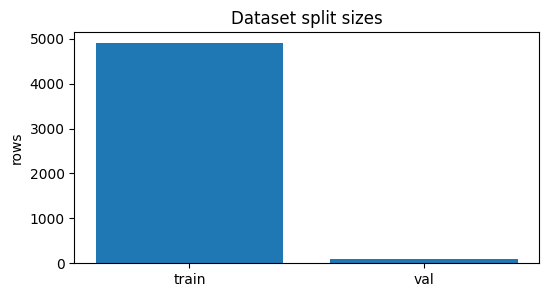

In [13]:
# =========================
# 7.1) Visualization: dataset split & schema summary (sizes + missingness)
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _pct_missing(s: pd.Series) -> float:
    return float(s.isna().mean() * 100.0)

def _len_stats(s: pd.Series) -> dict:
    x = s.dropna().astype(str).map(len)
    if len(x) == 0:
        return {"mean": np.nan, "p50": np.nan, "p95": np.nan, "max": np.nan}
    return {
        "mean": float(x.mean()),
        "p50": float(np.percentile(x, 50)),
        "p95": float(np.percentile(x, 95)),
        "max": float(x.max()),
    }

rows = []
for split_name, df_ in [("train", train_df_split), ("val", val_df)]:
    row = {
        "split": split_name,
        "rows": int(len(df_)),
        "q_col": q_col,
        "a_col": a_col,
        "id_col": id_col,
    }
    if q_col is not None and q_col in df_.columns:
        row["q_missing_%"] = _pct_missing(df_[q_col])
        q_stats = _len_stats(df_[q_col])
        row["q_chars_mean"] = q_stats["mean"]
        row["q_chars_p95"] = q_stats["p95"]
        row["q_chars_max"] = q_stats["max"]
    if a_col is not None and a_col in df_.columns:
        row["a_missing_%"] = _pct_missing(df_[a_col])
        a_stats = _len_stats(df_[a_col])
        row["a_chars_mean"] = a_stats["mean"]
        row["a_chars_p95"] = a_stats["p95"]
        row["a_chars_max"] = a_stats["max"]
    rows.append(row)

summary_df = pd.DataFrame(rows)
display(summary_df)

plt.figure(figsize=(6, 3))
plt.bar(summary_df["split"], summary_df["rows"])
plt.title("Dataset split sizes")
plt.ylabel("rows")
plt.show()


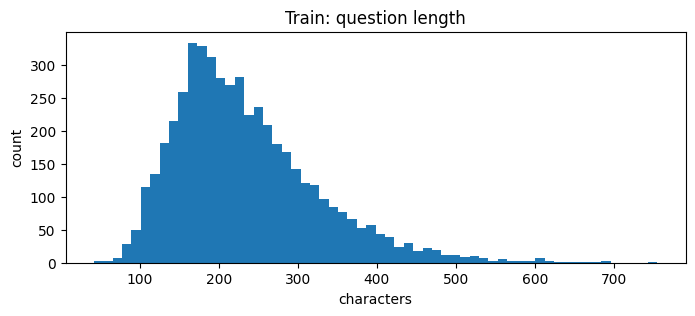

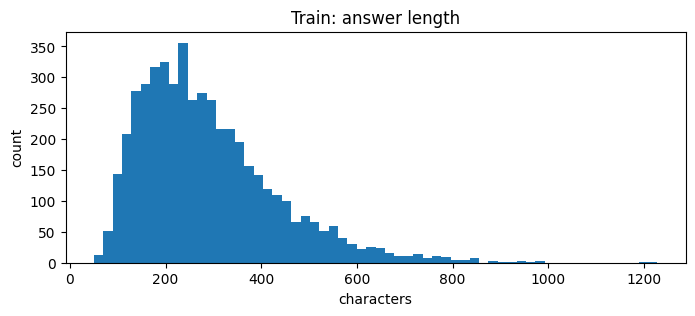

In [14]:
# =========================
# 7.2) Visualization: question/answer length distributions (chars)
# =========================
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(series: pd.Series, title: str, bins: int = 60):
    x = series.dropna().astype(str).map(len)
    if len(x) == 0:
        print(f"⚠️ No data for: {title}")
        return
    plt.figure(figsize=(8, 3))
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel("characters")
    plt.ylabel("count")
    plt.show()

# Use the split we actually train on
if q_col in train_df_split.columns:
    plot_hist(train_df_split[q_col], f"Train: {q_col} length")
if a_col is not None and a_col in train_df_split.columns:
    plot_hist(train_df_split[a_col], f"Train: {a_col} length")


In [15]:

# =========================
# 8) Dataset diagnostics (what will be used and how)
# =========================
from collections import Counter


# How much data will SFT / GRPO actually consume?
sft_n = min(SFT_MAX_EXAMPLES, len(train_df_split)) if RUN_SFT else 0
grpo_train_n = min(GRPO_MAX_TRAIN_EXAMPLES, len(train_df_split)) if RUN_GRPO else 0
grpo_val_n = min(GRPO_MAX_EVAL_EXAMPLES, len(val_df)) if RUN_GRPO else 0

print("=== Dataset usage plan ===")
print(f"Total train rows available: {len(train_df_split)}")
print(f"Total val rows available:   {len(val_df)}")
print("")
print("SFT seeding:")
print(f"  RUN_SFT={RUN_SFT}")
print(f"  Using up to: {sft_n} examples (cap: SFT_MAX_EXAMPLES={SFT_MAX_EXAMPLES})")
print(f"  Technique: supervised fine-tuning (teacher forcing) with LoRA adapters")
print("")
print("GRPO:")
print(f"  RUN_GRPO={RUN_GRPO}")
print(f"  Using up to: {grpo_train_n} train examples (cap: GRPO_MAX_TRAIN_EXAMPLES={GRPO_MAX_TRAIN_EXAMPLES})")
print(f"  Using up to: {grpo_val_n}   eval examples (cap: GRPO_MAX_EVAL_EXAMPLES={GRPO_MAX_EVAL_EXAMPLES})")
print(f"  Technique: reinforcement learning (GRPO) with num_generations={NUM_GENERATIONS}, num_iterations={NUM_ITERATIONS}")
print("")

# Prompt length sanity (character-based, cheap)
if len(train_df_split) > 0:
    sample_prompts = [build_prompt(to_str(x)) for x in train_df_split[q_col].head(min(200, len(train_df_split)))]
    lengths = np.array([len(p) for p in sample_prompts])
    print("Prompt length (chars) on a small sample:")
    print("  min/median/max:", int(lengths.min()), int(np.median(lengths)), int(lengths.max()))


=== Dataset usage plan ===
Total train rows available: 4900
Total val rows available:   100

SFT seeding:
  RUN_SFT=True
  Using up to: 4000 examples (cap: SFT_MAX_EXAMPLES=4000)
  Technique: supervised fine-tuning (teacher forcing) with LoRA adapters

GRPO:
  RUN_GRPO=True
  Using up to: 2000 train examples (cap: GRPO_MAX_TRAIN_EXAMPLES=2000)
  Using up to: 100   eval examples (cap: GRPO_MAX_EVAL_EXAMPLES=200)
  Technique: reinforcement learning (GRPO) with num_generations=8, num_iterations=1

Prompt length (chars) on a small sample:
  min/median/max: 398 530 845


## Model loading (Gemma + Tunix) and LoRA setup

In [16]:

# =========================
# 9) Locate Gemma model directory (Transformers-style)
# =========================
from pathlib import Path

def find_model_dir(root: Path, prefer_substring: str | None = None) -> Path | None:
    """
    Tries to locate a local HuggingFace Transformers model directory under `root`
    by searching for config.json and one or more *.safetensors files.
    """
    root = Path(root)
    candidates: list[Path] = []
    for cfg_path in root.rglob("config.json"):
        d = cfg_path.parent
        has_weights = any(d.glob("*.safetensors")) or (d / "model.safetensors").exists()
        has_tokenizer = (d / "tokenizer.model").exists() or (d / "tokenizer.json").exists()
        if has_weights and has_tokenizer:
            candidates.append(d)

    if not candidates:
        return None

    if prefer_substring:
        prefer = prefer_substring.lower()
        preferred = [c for c in candidates if prefer in str(c).lower()]
        if preferred:
            # prefer shortest path (more specific)
            preferred.sort(key=lambda p: len(str(p)))
            return preferred[0]

    candidates.sort(key=lambda p: len(str(p)))
    return candidates[0]

local_model_path = Path(cfg.model.local_dir) if cfg.model.local_dir else None
if local_model_path is None:
    local_model_path = find_model_dir(KAGGLE_INPUT, prefer_substring=cfg.model.prefer)

if local_model_path is None or not local_model_path.exists():
    raise FileNotFoundError(
        "Could not locate Gemma weights under /kaggle/input. "
        "Set model.local_dir in config.yaml to the exact Transformers directory "
        "(the folder containing config.json + *.safetensors + tokenizer.*)."
    )

print("✅ local_model_path:", local_model_path)

tokenizer_path = local_model_path / "tokenizer.model"
if not tokenizer_path.exists():
    # Some models ship tokenizer.json instead; tokenizer_adapter supports tokenizer.model best.
    print("⚠️ tokenizer.model not found. tokenizer_adapter may still work if tokenizer.json exists.")


✅ local_model_path: /kaggle/input/gemma-3/transformers/gemma-3-1b-it/1


MODEL_DIR_RESOLVED: /kaggle/input/gemma-3/transformers/gemma-3-1b-it/1


/usr/local/lib/python3.12/site-packages/torch_xla/__init__.py:258: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


,prompt_tokens_mean,prompt_tokens_p95,prompt_tokens_max,answer_tokens_mean,answer_tokens_p95,answer_tokens_max
0,144.0765,183.0,244.0,124.172,226.05,433.0


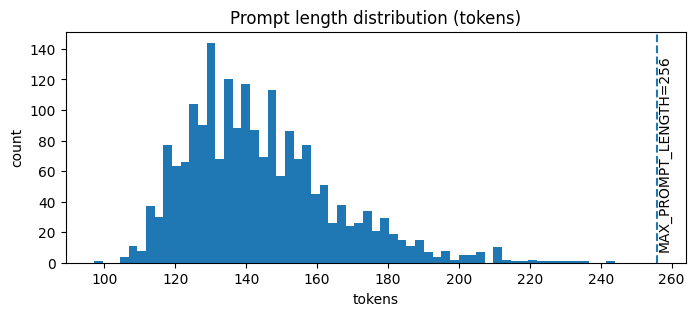

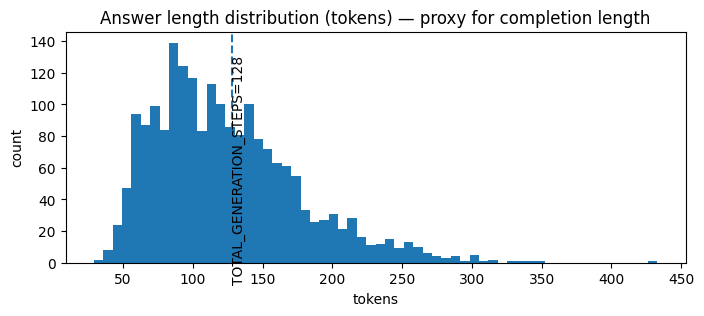

Notes:
 - SFT_MAX_SEQ_LEN bounds prompt+target after truncation/masking.
 - MAX_PROMPT_LENGTH bounds the prompt tokens used for GRPO rollouts.
 - TOTAL_GENERATION_STEPS bounds the maximum generated tokens during GRPO rollouts.


In [17]:
# =========================
# 9.1) Visualization: token-length stats (justify max_seq_len / prompt_len / gen_len) — FIXED
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Resolve MODEL_DIR robustly (no dependency on earlier cells)
MODEL_DIR_RESOLVED = None

# 1) Use existing MODEL_DIR if already defined
if "MODEL_DIR" in globals() and MODEL_DIR is not None:
    MODEL_DIR_RESOLVED = Path(MODEL_DIR)

# 2) Else use cfg.model.local_dir if set
elif "cfg" in globals() and getattr(cfg.model, "local_dir", None):
    MODEL_DIR_RESOLVED = Path(cfg.model.local_dir)

# 3) Else default to Kaggle Gemma input path
else:
    MODEL_DIR_RESOLVED = Path("/kaggle/input/gemma-3/transformers/gemma-3-1b-it/1")

print("MODEL_DIR_RESOLVED:", MODEL_DIR_RESOLVED)

_tok = None
try:
    from transformers import AutoTokenizer
    if MODEL_DIR_RESOLVED.exists():
        _tok = AutoTokenizer.from_pretrained(str(MODEL_DIR_RESOLVED), local_files_only=True, use_fast=True)
        if _tok.pad_token_id is None:
            _tok.pad_token = _tok.eos_token
    else:
        print("⚠️ MODEL_DIR_RESOLVED does not exist; cannot load HF tokenizer.")
except Exception as e:
    print("⚠️ Could not load HF tokenizer for token-length stats:", repr(e))
    _tok = None

def token_len(text: str) -> int:
    if _tok is None:
        return -1
    return int(len(_tok(str(text), add_special_tokens=False).input_ids))

if _tok is None:
    print("⚠️ Skipping token-length histograms (tokenizer unavailable).")
else:
    # Sample to keep it fast
    _df = train_df_split
    n = min(2000, len(_df))
    sample = _df.sample(n=n, random_state=int(cfg.data.seed)) if len(_df) > n else _df.copy()

    # Prompt tokens (true prompt length used by GRPO)
    prompt_lens = sample[q_col].astype(str).map(lambda q: token_len(build_prompt(q)))

    # Answer tokens (proxy for completion length; optional)
    ans_lens = None
    if a_col is not None and a_col in sample.columns:
        ans_lens = sample[a_col].astype(str).map(token_len)

    stats = {
        "prompt_tokens_mean": float(prompt_lens.mean()),
        "prompt_tokens_p95": float(np.percentile(prompt_lens, 95)),
        "prompt_tokens_max": float(prompt_lens.max()),
    }
    if ans_lens is not None:
        stats.update({
            "answer_tokens_mean": float(ans_lens.mean()),
            "answer_tokens_p95": float(np.percentile(ans_lens, 95)),
            "answer_tokens_max": float(ans_lens.max()),
        })

    display(pd.DataFrame([stats]))

    # Prompt token histogram (GRPO max_prompt_length)
    plt.figure(figsize=(8, 3))
    plt.hist(prompt_lens, bins=60)
    plt.title("Prompt length distribution (tokens)")
    plt.xlabel("tokens")
    plt.ylabel("count")
    plt.axvline(int(MAX_PROMPT_LENGTH), linestyle="--")
    plt.text(int(MAX_PROMPT_LENGTH), plt.ylim()[1]*0.9, f"MAX_PROMPT_LENGTH={MAX_PROMPT_LENGTH}", rotation=90, va="top")
    plt.show()

    # Answer token histogram (proxy for completion length)
    if ans_lens is not None:
        plt.figure(figsize=(8, 3))
        plt.hist(ans_lens, bins=60)
        plt.title("Answer length distribution (tokens) — proxy for completion length")
        plt.xlabel("tokens")
        plt.ylabel("count")
        plt.axvline(int(TOTAL_GENERATION_STEPS), linestyle="--")
        plt.text(int(TOTAL_GENERATION_STEPS), plt.ylim()[1]*0.9, f"TOTAL_GENERATION_STEPS={TOTAL_GENERATION_STEPS}", rotation=90, va="top")
        plt.show()

    print("Notes:")
    print(" - SFT_MAX_SEQ_LEN bounds prompt+target after truncation/masking.")
    print(" - MAX_PROMPT_LENGTH bounds the prompt tokens used for GRPO rollouts.")
    print(" - TOTAL_GENERATION_STEPS bounds the maximum generated tokens during GRPO rollouts.")

In [18]:

# =========================
# 10) Load base model on TPU (Tunix + safe tensors)
# =========================
import qwix
from flax import nnx

# Tunix imports (Gemma family-specific)
if MODEL_FAMILY == "gemma3":
    from tunix.models.gemma3 import model as gemma_lib
    from tunix.models.gemma3 import params_safetensors as params_safetensors_lib
    from tunix.models.gemma3 import params as gemma_params
elif MODEL_FAMILY == "gemma2":
    from tunix.models.gemma2 import model as gemma_lib
    from tunix.models.gemma2 import params as gemma_params
    # Gemma2 typically uses orbax checkpoints in Tunix demos; safe tensors support may differ.
    raise NotImplementedError("This notebook currently focuses on gemma3 safe-tensors loading.")
else:
    raise ValueError(f"Unsupported MODEL_FAMILY={MODEL_FAMILY}")

from tunix.generate import tokenizer_adapter as tokenizer_lib

# dtype mapping
DTYPE_MAP = {
    "bfloat16": jnp.bfloat16,
    "float16": jnp.float16,
    "float32": jnp.float32,
}
DTYPE = DTYPE_MAP[DTYPE_STR]

print("\n--- HBM BEFORE model load ---")
show_hbm_usage()

# Model config for Gemma3-1B
model_config = gemma_lib.ModelConfig.gemma3_1b()

with mesh:
    base_model = params_safetensors_lib.create_model_from_safe_tensors(
        str(local_model_path),
        model_config,
        mesh,
        dtype=DTYPE,
    )

print("\n--- HBM AFTER base model load ---")
show_hbm_usage()

# Tokenizer (prefer local tokenizer.model)
tokenizer = tokenizer_lib.Tokenizer(tokenizer_path=str(tokenizer_path))

# EOS tokens
EOS_TOKENS = list(dict.fromkeys([*cfg.model.eos_tokens]))
print("EOS_TOKENS:", EOS_TOKENS)



--- HBM BEFORE model load ---
TPU_0(process=0,(0,0,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_1(process=0,(1,0,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_2(process=0,(0,1,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_3(process=0,(1,1,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_4(process=0,(0,2,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_5(process=0,(1,2,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_6(process=0,(0,3,0,0)): 0.00 GiB / 15.75 GiB (0.0%)
TPU_7(process=0,(1,3,0,0)): 0.00 GiB / 15.75 GiB (0.0%)

--- HBM AFTER base model load ---
TPU_0(process=0,(0,0,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_1(process=0,(1,0,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_2(process=0,(0,1,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_3(process=0,(1,1,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_4(process=0,(0,2,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_5(process=0,(1,2,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_6(process=0,(0,3,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
TPU_7(process=0,(1,3,0,0)): 0.23 GiB / 15.75 GiB (1.5%)
EOS_TOKENS: [1, 106]


In [19]:

# =========================
# 11) Apply LoRA (critical: use model-provided sharded inputs)
# =========================
lora_provider = qwix.LoraProvider(
    module_path=LORA_MODULE_PATH,
    rank=RANK,
    alpha=ALPHA,
)

with mesh:
    # Model-provided inputs ensure correct sharding for this model+mesh (prevents gather sharding ambiguity)
    model_input = base_model.get_model_input()
    lora_policy = qwix.apply_lora_to_model(
        base_model,
        lora_provider,
        rngs=nnx.Rngs(params=0, lora=1),
        **model_input,
    )

print("✅ LoRA model created.")
print("\n--- HBM AFTER LoRA apply ---")
show_hbm_usage()


✅ LoRA model created.

--- HBM AFTER LoRA apply ---
TPU_0(process=0,(0,0,0,0)): 0.39 GiB / 15.75 GiB (2.5%)
TPU_1(process=0,(1,0,0,0)): 0.39 GiB / 15.75 GiB (2.4%)
TPU_2(process=0,(0,1,0,0)): 0.39 GiB / 15.75 GiB (2.4%)
TPU_3(process=0,(1,1,0,0)): 0.39 GiB / 15.75 GiB (2.4%)
TPU_4(process=0,(0,2,0,0)): 0.39 GiB / 15.75 GiB (2.4%)
TPU_5(process=0,(1,2,0,0)): 0.39 GiB / 15.75 GiB (2.4%)
TPU_6(process=0,(0,3,0,0)): 0.39 GiB / 15.75 GiB (2.4%)
TPU_7(process=0,(1,3,0,0)): 0.39 GiB / 15.75 GiB (2.4%)


In [20]:
from pathlib import Path

p = MERGED_LORA_DIR
print("Dir exists:", p.exists())
if p.exists():
    files = sorted([x.name for x in p.iterdir()])
    print("Files:", files[:50])
    print("Has config.json:", (p / "config.json").exists())
    print("Has model.safetensors:", (p / "model.safetensors").exists())
    print("Has tokenizer.json:", (p / "tokenizer.json").exists())
    print("Has tokenizer.model:", (p / "tokenizer.model").exists())
else:
    print("Directory not created yet (normal before export).")

Dir exists: False
Directory not created yet (normal before export).


In [21]:
# =========================
# Skip logic (single-session): checkpoints exist?
# =========================
from pathlib import Path

def ckpt_is_present(ckpt_dir: Path) -> bool:
    return ckpt_dir.exists() and any(ckpt_dir.rglob("*"))

SFT_CKPT_PRESENT = ckpt_is_present(CKPT_DIR / "sft_seed")
GRPO_CKPT_PRESENT = ckpt_is_present(CKPT_DIR / "grpo")

print("SFT_CKPT_PRESENT:", SFT_CKPT_PRESENT, "|", CKPT_DIR / "sft_seed")
print("GRPO_CKPT_PRESENT:", GRPO_CKPT_PRESENT, "|", CKPT_DIR / "grpo")

SFT_CKPT_PRESENT: False | /kaggle/working/checkpoints/google_gemma-3-1b-it_tunix_sft_grpo/sft_seed
GRPO_CKPT_PRESENT: False | /kaggle/working/checkpoints/google_gemma-3-1b-it_tunix_sft_grpo/grpo


In [22]:
# =========================
# Export merged model directory (creates MERGED_LORA_DIR)
# =========================
from pathlib import Path
import shutil

EXPORT_DIR = Path(cfg.export.export_root) / cfg.export.run_name
MERGED_LORA_DIR = EXPORT_DIR / cfg.export.merged_subdir
MERGED_LORA_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Created:", MERGED_LORA_DIR)
print("Export root:", EXPORT_DIR)

# (Your existing export code should write config.json, tokenizer.*, model.safetensors here.)
# After export, verify:
required = ["config.json", "model.safetensors"]
print({f: (MERGED_LORA_DIR / f).exists() for f in required})

✅ Created: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
Export root: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo
{'config.json': False, 'model.safetensors': False}


In [23]:

# =========================
# 12) Skip logic: if exported merged model exists, skip training
# =========================
def export_is_present(model_dir: Path) -> bool:
    if not model_dir.exists():
        return False
    has_weights = any(model_dir.glob("*.safetensors")) or (model_dir / "model.safetensors").exists()
    has_cfg = (model_dir / "config.json").exists()
    has_tokenizer = (model_dir / "tokenizer.json").exists() or (model_dir / "tokenizer.model").exists()
    return bool(has_weights and has_cfg and has_tokenizer)

EXPORT_PRESENT = export_is_present(MERGED_LORA_DIR)
print("EXPORT_PRESENT:", EXPORT_PRESENT, "|", MERGED_LORA_DIR)

if FORCE_RETRAIN:
    print("⚠️ force_retrain=true: will retrain even if export exists.")


EXPORT_PRESENT: False | /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora


## Stage 1 — LoRA SFT (format seeding)

In [24]:
# =========================
# 13) Build SFT dataset (TrainingInput) — tokenized + masked (FIXED, self-contained)
# =========================
import numpy as np
import grain
from typing import List
import re
from dataclasses import fields, is_dataclass

from tunix.sft import peft_trainer

# Ensure we have an HF tokenizer for tokenization/padding
# Prefer existing `hf_tok` or `tok`; otherwise build from model dir.
from transformers import AutoTokenizer

if "hf_tok" in globals() and hf_tok is not None:
    _hf = hf_tok
elif "tok" in globals() and tok is not None:
    _hf = tok
else:
    # fall back to model dir
    assert local_model_path is not None, "local_model_path is not set"
    _hf = AutoTokenizer.from_pretrained(str(local_model_path), local_files_only=True, use_fast=True)

if _hf.pad_token_id is None:
    _hf.pad_token = _hf.eos_token

SFT_MAX_SEQ_LEN = int(cfg.sft.max_seq_len)

# --- Helper: build TrainingInput robustly (field names can vary by Tunix version)
TI = peft_trainer.TrainingInput
ti_fields = [f.name for f in fields(TI)] if is_dataclass(TI) else []
print("TrainingInput fields:", ti_fields)

def make_training_input(input_tokens: np.ndarray, input_mask: np.ndarray):
    kwargs = {}
    if "input_tokens" in ti_fields:
        kwargs["input_tokens"] = input_tokens
    if "input_mask" in ti_fields:
        kwargs["input_mask"] = input_mask
    # fallback if reflection differs
    if not kwargs:
        kwargs = dict(input_tokens=input_tokens, input_mask=input_mask)
    return TI(**kwargs)

# --- Tokenize function (prompt + target) -> TrainingInput
def tokenize_sft(prompt: str, target: str) -> peft_trainer.TrainingInput:
    """
    Produces:
      - input_tokens: padded token ids of (prompt + target)
      - input_mask:  1s for target tokens only, 0s for prompt tokens (loss mask)
    """
    full_text = prompt + target

    prompt_ids = _hf(prompt, add_special_tokens=False).input_ids
    full_ids = _hf(
        full_text,
        add_special_tokens=False,
        truncation=True,
        max_length=SFT_MAX_SEQ_LEN,
    ).input_ids

    # start index where target begins (may truncate)
    start = min(len(prompt_ids), len(full_ids))

    # Pad to fixed length
    pad_id = int(_hf.pad_token_id)
    input_tokens = np.full((SFT_MAX_SEQ_LEN,), pad_id, dtype=np.int32)
    input_tokens[:len(full_ids)] = np.array(full_ids, dtype=np.int32)

    # Loss mask: only target region gets 1
    input_mask = np.zeros((SFT_MAX_SEQ_LEN,), dtype=np.int32)
    input_mask[start:len(full_ids)] = 1

    return make_training_input(input_tokens, input_mask)

# If your dataset has no answers, SFT is not meaningful.
if a_col is None:
    print("⚠️ a_col is None — SFT will be skipped (no supervised targets).")
    sft_ds = None
else:
    # Convert dataset answers into the required XML format:
    #   <reasoning>...</reasoning>
    #   <answer>...</answer>
    _NUM_RE = re.compile(r"-?\d+(?:\.\d+)?")

    def to_xml_target(raw: str) -> str:
        raw = to_str(raw)

        if "####" in raw:
            reasoning, final = raw.split("####", 1)
        else:
            reasoning = raw
            nums = _NUM_RE.findall(raw)
            final = nums[-1] if nums else (raw.strip().splitlines()[-1] if raw.strip() else "")

        reasoning = reasoning.strip()
        final = str(final).strip()

        # Required tag format
        return f"<reasoning>{reasoning}</reasoning>\n<answer>{final}</answer>"

    SFT_MAX_EXAMPLES = int(cfg.sft.max_examples)
    sft_n = min(SFT_MAX_EXAMPLES, len(train_df_split))
    sft_rows = train_df_split.head(sft_n)

    sft_inputs: List[peft_trainer.TrainingInput] = []
    for _, row in sft_rows.iterrows():
        q = to_str(row[q_col])
        raw_a = to_str(row[a_col])

        prompt = build_prompt(q)          # uses your TEMPLATE/SYSTEM_PROMPT
        target = to_xml_target(raw_a)     # supervised target

        sft_inputs.append(tokenize_sft(prompt, target))

    print(f"✅ Built SFT inputs: {len(sft_inputs)} examples | seq_len={SFT_MAX_SEQ_LEN}")

    # Grain dataset: shuffle + batch + repeat
    sft_ds = (
        grain.MapDataset.source(sft_inputs)
        .shuffle(seed=int(cfg.data.seed))
        .batch(int(cfg.sft.global_batch_size))
        .repeat()
    )

TrainingInput fields: ['input_tokens', 'input_mask']
✅ Built SFT inputs: 4000 examples | seq_len=512


In [25]:
# =========================
# 14) TRAINING: Stage 1 — LoRA SFT seeding (FIXED: no tunix.sft.sft_utils dependency)
# =========================
import optax
import jax
import jax.numpy as jnp
from tunix.sft import metrics_logger

# ---------------------------------------------------------------------
# 0) Resolve PAD_ID from tokenizer used for SFT tokenization
# ---------------------------------------------------------------------
PAD_ID = None
if "hf_tok" in globals() and hf_tok is not None and getattr(hf_tok, "pad_token_id", None) is not None:
    PAD_ID = int(hf_tok.pad_token_id)
elif "_hf" in globals() and _hf is not None and getattr(_hf, "pad_token_id", None) is not None:
    PAD_ID = int(_hf.pad_token_id)
elif "tok" in globals() and tok is not None and getattr(tok, "pad_token_id", None) is not None:
    PAD_ID = int(tok.pad_token_id)

if PAD_ID is None:
    raise RuntimeError("Could not resolve PAD_ID. Ensure your HF tokenizer is loaded and has pad_token_id.")

# ---------------------------------------------------------------------
# 1) Provide sft_utils functions (try import; else fallback implementation)
# ---------------------------------------------------------------------
_build_positions = None
_make_causal_mask = None

# Try a few likely locations (different Tunix versions)
try:
    from tunix.sft import utils as _u  # some builds use tunix.sft.utils
    _build_positions = getattr(_u, "build_positions_from_mask", None)
    _make_causal_mask = getattr(_u, "make_causal_attn_mask", None)
except Exception:
    pass

try:
    import tunix
    # sometimes utilities are under tunix.sft._src or similar
    # (best-effort; ignore failures)
    from tunix.sft import input_utils as _iu  # noqa
    _build_positions = _build_positions or getattr(_iu, "build_positions_from_mask", None)
    _make_causal_mask = _make_causal_mask or getattr(_iu, "make_causal_attn_mask", None)
except Exception:
    pass

def build_positions_from_mask(pad_mask):
    """
    pad_mask: [B, T] bool or {0,1}
    returns positions: [B, T] int32, where padded tokens get 0.
    """
    pm = jnp.asarray(pad_mask).astype(jnp.int32)
    # positions count up only where pm==1
    pos = jnp.cumsum(pm, axis=1) - 1
    pos = jnp.maximum(pos, 0)
    pos = pos * pm
    return pos.astype(jnp.int32)

def make_causal_attn_mask(pad_mask):
    """
    Returns an additive causal attention mask suitable for most transformer implementations.
    Shape: [B, 1, T, T], dtype float32
    Allowed positions have 0.0; disallowed positions have a large negative number.
    """
    pm = jnp.asarray(pad_mask).astype(jnp.bool_)
    B, T = pm.shape
    # causal (lower triangular)
    causal = jnp.tril(jnp.ones((T, T), dtype=jnp.bool_))
    # allow only attending to real (non-pad) keys
    key_mask = pm[:, None, None, :]                 # [B,1,1,T]
    # allow only for real (non-pad) queries as well (optional)
    query_mask = pm[:, None, :, None]               # [B,1,T,1]
    allowed = causal[None, None, :, :] & key_mask & query_mask  # [B,1,T,T]
    neg = jnp.array(-1e9, dtype=jnp.float32)
    return jnp.where(allowed, 0.0, neg).astype(jnp.float32)

# If Tunix provided implementations exist, use them; else fallback
if callable(_build_positions):
    build_positions_from_mask = _build_positions
if callable(_make_causal_mask):
    make_causal_attn_mask = _make_causal_mask

print("Using build_positions_from_mask:", build_positions_from_mask.__module__)
print("Using make_causal_attn_mask     :", make_causal_attn_mask.__module__)

# ---------------------------------------------------------------------
# 2) Gate logic
# ---------------------------------------------------------------------
RUN_SFT_EFFECTIVE = RUN_SFT and (sft_ds is not None) and not (EXPORT_PRESENT and SKIP_IF_EXPORT_EXISTS and not FORCE_RETRAIN)

if not RUN_SFT_EFFECTIVE:
    print("⚠️ Skipping SFT seeding.")
    if not RUN_SFT:
        print("  - cfg.sft.enabled=false")
    elif sft_ds is None:
        print("  - sft_ds is None (likely missing answers)")
    elif EXPORT_PRESENT and SKIP_IF_EXPORT_EXISTS and not FORCE_RETRAIN:
        print("  - Exported model already present and skip_training_if_export_exists=true")
else:
    SFT_CKPT_DIR = CKPT_DIR / "sft_seed"
    SFT_CKPT_DIR.mkdir(parents=True, exist_ok=True)

    sft_logging_options = metrics_logger.MetricsLoggerOptions(
        log_dir=str(TB_DIR / "sft_seed"),
        flush_every_n_steps=10,
    )

    training_config = peft_trainer.TrainingConfig(
        eval_every_n_steps=SFT_EVAL_EVERY,
        max_steps=SFT_MAX_STEPS,
        metrics_logging_options=sft_logging_options,
        checkpoint_root_directory=str(SFT_CKPT_DIR),
    )

    def gen_model_input_fn(x: peft_trainer.TrainingInput):
        pad_mask = (x.input_tokens != PAD_ID)
        positions = build_positions_from_mask(pad_mask)
        attention_mask = make_causal_attn_mask(pad_mask)
        return {
            "input_tokens": x.input_tokens,
            "input_mask": x.input_mask,
            "positions": positions,
            "attention_mask": attention_mask,
        }

    sft_optimizer = optax.adamw(
        learning_rate=SFT_LEARNING_RATE,
        b1=SFT_B1,
        b2=SFT_B2,
        weight_decay=SFT_WEIGHT_DECAY,
    )

    sft_trainer = (
        peft_trainer.PeftTrainer(lora_policy, sft_optimizer, training_config)
        .with_gen_model_input_fn(gen_model_input_fn)
    )

    print("Starting SFT seeding...")
    print("Backend:", jax.default_backend())
    print("PAD_ID:", PAD_ID)
    print("SFT_LEARNING_RATE:", SFT_LEARNING_RATE, "(global batch:", SFT_GLOBAL_BATCH_SIZE, ")")
    print("SFT_MAX_STEPS:", SFT_MAX_STEPS)

    with mesh:
        sft_trainer.train(sft_ds, None)  # change to sft_eval_ds if you built it

    print("✅ SFT seeding complete.")



# =========================
# 15) Export merged model (base + LoRA) for inference (HF-compatible directory)
# =========================
import shutil
import json
import time

def export_merged_lora(output_dir: Path) -> Path:
    """
    Writes a HuggingFace-style directory with merged LoRA weights.
    Returns the output_dir path.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Merge base + lora and save as safetensors
    # (Gemma3 helper provided by Tunix)
    gemma_params.save_lora_merged_model_as_safetensors(
        str(local_model_path),
        str(output_dir),
        lora_policy,
        rank=RANK,
        alpha=ALPHA,
    )

    # Copy tokenizer/config artifacts expected by HF loaders
    for fname in [
        "config.json",
        "generation_config.json",
        "tokenizer.model",
        "tokenizer.json",
        "tokenizer_config.json",
        "special_tokens_map.json",
        "added_tokens.json",
    ]:
        src = local_model_path / fname
        dst = output_dir / fname
        if src.exists() and not dst.exists():
            shutil.copy2(src, dst)

    # Save run metadata
    meta = {
        "run_name": RUN_NAME,
        "model_id": MODEL_ID,
        "local_model_path": str(local_model_path),
        "dtype": DTYPE_STR,
        "lora_rank": RANK,
        "lora_alpha": ALPHA,
        "sft": cfg.sft.model_dump(),
        "grpo": cfg.grpo.model_dump(),
        "data": {
            "train_path": str(train_path),
            "eval_path": str(eval_path) if eval_path else None,
            "q_col": q_col,
            "a_col": a_col,
            "r_col": r_col,
            "id_col": id_col,
            "train_rows_used": len(train_df_split),
            "val_rows_used": len(val_df),
        },
        "timestamp_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    }
    (output_dir / "tunix_run_metadata.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

    # Also store the exact config.yaml used
    shutil.copy2(CONFIG_PATH, output_dir / "config.yaml")

    return output_dir

if cfg.export.enabled and cfg.export.save_after_sft and RUN_SFT_EFFECTIVE:
    print("Exporting merged model after SFT to:", MERGED_LORA_DIR)
    out_dir = export_merged_lora(MERGED_LORA_DIR)
    print("✅ Export complete:", out_dir)
else:
    print("ℹ️ Skipping export after SFT (either disabled or SFT didn't run).")


# =========================
# 18.2) Optional: zip merged_lora for easy upload (Kaggle Dataset / Model)
# =========================
import shutil
from pathlib import Path

merged_dir = Path(MERGED_LORA_DIR)
zip_out = Path("/kaggle/working") / f"{RUN_NAME}_merged_lora.zip"

if not merged_dir.exists():
    print("⚠️ merged_lora directory not found:", merged_dir)
else:
    base_name = str(zip_out).replace(".zip", "")
    if Path(base_name + ".zip").exists():
        print("✅ Zip already exists:", base_name + ".zip")
    else:
        # zip will contain a top-level folder named merged_lora/
        shutil.make_archive(base_name, "zip", root_dir=str(merged_dir.parent), base_dir=merged_dir.name)
        print("✅ Wrote zip:", base_name + ".zip")



Using build_positions_from_mask: tunix.sft.utils
Using make_causal_attn_mask     : tunix.sft.utils
Starting SFT seeding...
Backend: tpu
PAD_ID: 0
SFT_LEARNING_RATE: 2e-05 (global batch: 64 )
SFT_MAX_STEPS: 50


Training:   0%|          | 0/50 [00:00<?, ?step/s]

✅ SFT seeding complete.
Exporting merged model after SFT to: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
✅ Export complete: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
✅ Wrote zip: /kaggle/working/google_gemma-3-1b-it_tunix_sft_grpo_merged_lora.zip


In [26]:
print('test')

test


In [27]:

# =========================
# 15) Export merged model (base + LoRA) for inference (HF-compatible directory)
# =========================
import shutil
import json
import time

def export_merged_lora(output_dir: Path) -> Path:
    """
    Writes a HuggingFace-style directory with merged LoRA weights.
    Returns the output_dir path.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Merge base + lora and save as safetensors
    # (Gemma3 helper provided by Tunix)
    gemma_params.save_lora_merged_model_as_safetensors(
        str(local_model_path),
        str(output_dir),
        lora_policy,
        rank=RANK,
        alpha=ALPHA,
    )

    # Copy tokenizer/config artifacts expected by HF loaders
    for fname in [
        "config.json",
        "generation_config.json",
        "tokenizer.model",
        "tokenizer.json",
        "tokenizer_config.json",
        "special_tokens_map.json",
        "added_tokens.json",
    ]:
        src = local_model_path / fname
        dst = output_dir / fname
        if src.exists() and not dst.exists():
            shutil.copy2(src, dst)

    # Save run metadata
    meta = {
        "run_name": RUN_NAME,
        "model_id": MODEL_ID,
        "local_model_path": str(local_model_path),
        "dtype": DTYPE_STR,
        "lora_rank": RANK,
        "lora_alpha": ALPHA,
        "sft": cfg.sft.model_dump(),
        "grpo": cfg.grpo.model_dump(),
        "data": {
            "train_path": str(train_path),
            "eval_path": str(eval_path) if eval_path else None,
            "q_col": q_col,
            "a_col": a_col,
            "r_col": r_col,
            "id_col": id_col,
            "train_rows_used": len(train_df_split),
            "val_rows_used": len(val_df),
        },
        "timestamp_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    }
    (output_dir / "tunix_run_metadata.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

    # Also store the exact config.yaml used
    shutil.copy2(CONFIG_PATH, output_dir / "config.yaml")

    return output_dir

if cfg.export.enabled and cfg.export.save_after_sft and RUN_SFT_EFFECTIVE:
    print("Exporting merged model after SFT to:", MERGED_LORA_DIR)
    out_dir = export_merged_lora(MERGED_LORA_DIR)
    print("✅ Export complete:", out_dir)
else:
    print("ℹ️ Skipping export after SFT (either disabled or SFT didn't run).")


Exporting merged model after SFT to: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
✅ Export complete: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora


In [28]:
print('test')

test


In [29]:
# =========================
# 18.2) Optional: zip merged_lora for easy upload (Kaggle Dataset / Model)
# =========================
import shutil
from pathlib import Path

merged_dir = Path(MERGED_LORA_DIR)
zip_out = Path("/kaggle/working") / f"{RUN_NAME}_merged_lora.zip"

if not merged_dir.exists():
    print("⚠️ merged_lora directory not found:", merged_dir)
else:
    base_name = str(zip_out).replace(".zip", "")
    if Path(base_name + ".zip").exists():
        print("✅ Zip already exists:", base_name + ".zip")
    else:
        # zip will contain a top-level folder named merged_lora/
        shutil.make_archive(base_name, "zip", root_dir=str(merged_dir.parent), base_dir=merged_dir.name)
        print("✅ Wrote zip:", base_name + ".zip")


✅ Zip already exists: /kaggle/working/google_gemma-3-1b-it_tunix_sft_grpo_merged_lora.zip


## Stage 2 — GRPO (reinforcement learning)

We use **Group Relative Policy Optimization (GRPO)** to reinforce two things simultaneously:

1. **Strict XML output format**: `<reasoning>...</reasoning><answer>...</answer>`
2. **Reasoning quality**: coherent, sufficiently deep traces (with light encouragement for reflection/self-checking)

GRPO trains directly from model rollouts using a **critic-free** objective and compares each rollout against the *group average* (multiple generations per prompt). This is a good fit for small models and Kaggle TPU memory constraints.


### Why GRPO instead of PPO for this hackathon?

A top-tier reasoning submission on Kaggle TPUs is primarily limited by **memory and throughput**. GRPO is a strong choice because:

- **Critic-free**: PPO typically needs an additional value network (and often extra model copies), increasing HBM pressure. GRPO avoids this.
- **More samples per prompt**: memory saved can be spent on **larger group size (G)** — multiple reasoning trajectories per question in parallel. This reduces variance and improves learning signal quality.
- **Practical stability**: using a reference model + KL penalty keeps outputs fluent while still allowing the policy to deviate in the “reasoning subspace”.
- **Fits Kaggle constraints**: the 9-hour single-session mode rewards methods that converge quickly without complex multi-model setups.

In short: **GRPO trades a critic for more rollouts**, which is exactly what we want when teaching “show your work” behavior under strict compute limits.


In [30]:

# =========================
# 16) Pre-GRPO dataset report (sizes, sampling, what will be used)
# =========================
print("=== Pre-GRPO dataset report ===")
print("Technique: GRPO (Group Relative Policy Optimization) on-policy RL with num_generations samples per prompt.")
print("")

print("Data sources:")
print("  train_df_split rows:", len(train_df_split))
print("  val_df rows:", len(val_df))
print("")

print("Configured caps:")
print("  GRPO_MAX_TRAIN_EXAMPLES:", GRPO_MAX_TRAIN_EXAMPLES)
print("  GRPO_MAX_EVAL_EXAMPLES:", GRPO_MAX_EVAL_EXAMPLES)
print("")

train_use = min(GRPO_MAX_TRAIN_EXAMPLES, len(train_df_split))
val_use   = min(GRPO_MAX_EVAL_EXAMPLES, len(val_df))

print("Will use:")
print("  train examples:", train_use, f"({train_use/len(train_df_split)*100:.1f}% of available)" if len(train_df_split) else "")
print("  eval examples:",  val_use,   f"({val_use/len(val_df)*100:.1f}% of available)" if len(val_df) else "")
print("")

print("Batching:")
print("  TRAIN_MICRO_BATCH_SIZE:", TRAIN_MICRO_BATCH_SIZE)
print("  NUM_GENERATIONS:", NUM_GENERATIONS, "=> full_batch_size =", TRAIN_MICRO_BATCH_SIZE * NUM_GENERATIONS)
print("  MAX_PROMPT_LENGTH:", MAX_PROMPT_LENGTH)
print("  TOTAL_GENERATION_STEPS:", TOTAL_GENERATION_STEPS)
print("")

# Show a couple of samples
if len(train_df_split) > 0:
    _tmp = train_df_split[[q_col] + ([a_col] if a_col else [])].head(2)
    display(_tmp)


=== Pre-GRPO dataset report ===
Technique: GRPO (Group Relative Policy Optimization) on-policy RL with num_generations samples per prompt.

Data sources:
  train_df_split rows: 4900
  val_df rows: 100

Configured caps:
  GRPO_MAX_TRAIN_EXAMPLES: 2000
  GRPO_MAX_EVAL_EXAMPLES: 200

Will use:
  train examples: 2000 (40.8% of available)
  eval examples: 100 (100.0% of available)

Batching:
  TRAIN_MICRO_BATCH_SIZE: 4
  NUM_GENERATIONS: 8 => full_batch_size = 32
  MAX_PROMPT_LENGTH: 256
  TOTAL_GENERATION_STEPS: 128



,question,answer
0,Three-quarters of the oil from a 4000-liter ta...,Three-quarters of oil from the initially full ...
1,To try to get the class to eat more vegetables...,The students need eat 100 vegetables in total ...


### Reward design rationale (Rubric-as-Reward)

The hackathon requires **both**: (1) a correct final answer when possible and (2) a consistent, judge-parseable reasoning trace.

We therefore compose reward as a **small rubric**:

1. **Format / XML compliance (high priority)**  
   - Output must be exactly two top-level tags: `<reasoning>` and `<answer>`.  
   - If format is invalid, other rewards are **gated to 0** (prevents “correct answer, wrong format”).

2. **Answer correctness (when labels exist)**  
   - For GSM8K-style data, we compare the extracted `<answer>` against the ground truth (numeric match when possible).  
   - This encourages the model to keep the final answer accurate while learning to externalize reasoning.

3. **Reasoning quality (depth + reflection bonus)**  
   - Encourage a trace that is non-trivial (not a one-liner) by rewarding a reasonable reasoning length.  
   - Small bonus for *natural* self-checking language (“let me check”, “wait”, “verify”, etc.), capped to avoid keyword spam.

This is intentionally simple, reproducible, and runs fully inside a single Kaggle session.


In [31]:
# =========================
# 16) Reward functions (STRICT XML + gated + reflection bonus)
# =========================
import re
from typing import Optional, Sequence, List

# STRICT: exactly two top-level tags and nothing else (whitespace allowed).
_STRICT_XML_FULL_RE = re.compile(
    r"^\s*<reasoning>(?P<reason>.*?)</reasoning>\s*<answer>(?P<ans>.*?)</answer>\s*$",
    re.DOTALL | re.IGNORECASE,
)

# Non-anchored (debug/extraction helper).
_STRICT_XML_ANY_RE = re.compile(
    r"<reasoning>(?P<reason>.*?)</reasoning>\s*<answer>(?P<ans>.*?)</answer>",
    re.DOTALL | re.IGNORECASE,
)

_TAG_RE = re.compile(r"</?(reasoning|answer)>", re.IGNORECASE)

def _parse_strict_xml(text: str) -> tuple[bool, str, str]:
    """Return (ok, reasoning, answer).

    ok=True only if:
      - completion is EXACTLY <reasoning>...</reasoning><answer>...</answer> (plus whitespace)
      - no nested <reasoning>/<answer> tags appear inside either field
    """
    if text is None:
        return False, "", ""
    m = _STRICT_XML_FULL_RE.match(str(text).strip())
    if not m:
        return False, "", ""
    reason = (m.group("reason") or "").strip()
    ans = (m.group("ans") or "").strip()
    # Disallow nested tags inside either field
    if _TAG_RE.search(reason) or _TAG_RE.search(ans):
        return False, "", ""
    return True, reason, ans

# Reflection phrases: encourage self-checking but cap the bonus.
_REFLECTION_PHRASES = [
    "let me check", "let's check", "double-check", "double check", "verify",
    "wait", "hold on", "re-check", "recheck", "sanity check", "does that make sense",
    "i might be wrong", "mistake", "alternatively", "another way",
]

_NUM_RE = re.compile(r"-?\d+(?:\.\d+)?")

def _extract_number_like(s: str) -> str:
    m = _NUM_RE.findall(str(s))
    return m[-1] if m else ""

def _norm_text(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

# -------------------------------------------------------------------
# Reward 1) Format / XML compliance (high weight + hard negative)
# -------------------------------------------------------------------
def reward_format(prompts: Sequence[str], completions: Sequence[str], **kwargs) -> List[float]:
    """High-priority format reward.

    +2.0 if STRICT XML valid AND <answer> is non-empty.
    -2.0 otherwise (includes missing/empty answer).
    """
    out: List[float] = []
    for c in completions:
        ok, reason, ans = _parse_strict_xml(c)
        out.append(2.0 if (ok and bool(ans)) else -2.0)
    return out

# -------------------------------------------------------------------
# Reward 2) Answer correctness (gated by strict format)
# -------------------------------------------------------------------
def reward_answer(
    prompts: Sequence[str],
    completions: Sequence[str],
    *,
    answers: Optional[Sequence[str]] = None,
    **kwargs,
) -> List[float]:
    """Answer correctness reward.

    - Gated: returns 0 unless STRICT format is satisfied.
    - Numeric match when possible (GSM8K-style).
    """
    answers = answers or kwargs.get("answers", None) or kwargs.get("answer", None)
    out: List[float] = []

    for i, c in enumerate(completions):
        ok, reason, pred_ans = _parse_strict_xml(c)
        if not ok:
            out.append(0.0)
            continue
        if answers is None:
            out.append(0.0)
            continue

        gt = answers[i]
        if gt is None:
            out.append(0.0)
            continue

        pred_n = _extract_number_like(pred_ans)
        gt_n = _extract_number_like(gt)

        if pred_n and gt_n:
            out.append(2.0 if pred_n == gt_n else 0.0)
        else:
            out.append(2.0 if _norm_text(pred_ans) == _norm_text(gt) else 0.0)

    return out

# -------------------------------------------------------------------
# Reward 3) Reasoning quality (depth + reflection bonus; gated)
# -------------------------------------------------------------------
def reward_reasoning_quality(prompts: Sequence[str], completions: Sequence[str], **kwargs) -> List[float]:
    """Reasoning quality reward.

    Encourages:
      - non-trivial reasoning length
      - light reflection/self-checking language

    This is *gated* by strict XML compliance.
    """
    out: List[float] = []
    for c in completions:
        ok, reason, ans = _parse_strict_xml(c)
        if not ok:
            out.append(0.0)
            continue

        words = len(reason.split())

        # length ramp: 0 at <=20 words, 1 at >=120 words
        if words <= 20:
            len_score = 0.0
        elif words >= 120:
            len_score = 1.0
        else:
            len_score = (words - 20) / (120 - 20)

        text_low = " " + reason.lower() + " "
        hits = 0
        for ph in _REFLECTION_PHRASES:
            if ph in text_low:
                hits += 1

        # Up to +0.4 bonus, capped (prevents keyword spam)
        bonus = min(0.4, 0.08 * hits)

        # Slight down-weight if extremely long (prevents verbosity explosion)
        if words > 220:
            len_score *= 0.8

        out.append(float(min(1.4, len_score + bonus)))

    return out

REWARD_FNS = [reward_format, reward_answer, reward_reasoning_quality]
print("✅ Reward fns ready:", [fn.__name__ for fn in REWARD_FNS])


✅ Reward fns ready: ['reward_format', 'reward_answer', 'reward_reasoning_quality']


In [32]:
# =========================
# Diagnose rollout_config expectation in your Tunix build
# =========================
import inspect
import tunix
from tunix.rl import rl_cluster as rl_cluster_lib

print("tunix version:", getattr(tunix, "__version__", "unknown"))

# 1) What does ClusterConfig accept?
sig = inspect.signature(rl_cluster_lib.ClusterConfig)
print("\nrl_cluster_lib.ClusterConfig signature:\n", sig)

# 2) Is there ANY rollout config class under rl_cluster_lib?
cands = [name for name in dir(rl_cluster_lib) if "roll" in name.lower() or "gen" in name.lower() or "sampl" in name.lower()]
print("\nCandidate names in rl_cluster_lib containing roll/gen/sampl:")
print(cands)

# 3) Print the annotation/type of rollout_config parameter if present
params = sig.parameters
if "rollout_config" in params:
    p = params["rollout_config"]
    print("\nrollout_config param found:")
    print("  kind:", p.kind)
    print("  default:", p.default)
    print("  annotation:", p.annotation)
else:
    print("\nNo rollout_config parameter in ClusterConfig signature. (Good: you don't need it.)")

tunix version: 0.1.6

rl_cluster_lib.ClusterConfig signature:
 (*, role_to_mesh: dict[tunix.rl.rl_cluster.Role, jax._src.mesh.Mesh], role_to_logical_axis_rule: dict[tunix.rl.rl_cluster.Role, collections.abc.Sequence[tuple[str, str | tuple[str, ...] | None]]] | None = None, rollout_engine: str | type[tunix.rl.rollout.base_rollout.BaseRollout] = 'vanilla', offload_to_cpu: bool = False, training_config: tunix.rl.rl_cluster.RLTrainingConfig, rollout_config: dict[tunix.rl.rl_cluster.Mode, tunix.rl.rollout.base_rollout.RolloutConfig] | tunix.rl.rollout.base_rollout.RolloutConfig) -> None

Candidate names in rl_cluster_lib containing roll/gen/sampl:
['base_rollout', 'vanilla_rollout']

rollout_config param found:
  kind: KEYWORD_ONLY
  default: <class 'inspect._empty'>
  annotation: dict[tunix.rl.rl_cluster.Mode, tunix.rl.rollout.base_rollout.RolloutConfig] | tunix.rl.rollout.base_rollout.RolloutConfig


In [33]:
# =========================
# 18) TRAINING: Stage 2 — GRPO (Tunix 0.1.6 compatible)
# =========================
import math
import numpy as np
import grain
import optax
import orbax.checkpoint as ocp

from tunix.sft import metrics_logger
from tunix.rl import rl_cluster as rl_cluster_lib
from tunix.rl.rollout import base_rollout              # ✅ correct import path for 0.1.6
from tunix.rl.grpo.grpo_learner import GRPOLearner, GRPOConfig


def pick_divisor_microbatch(full_batch_size: int, preferred: int) -> int:
    """Largest <= preferred divisor of full_batch_size."""
    preferred = max(1, int(preferred))
    for mb in range(preferred, 0, -1):
        if full_batch_size % mb == 0:
            return mb
    return 1


RUN_GRPO_EFFECTIVE = RUN_GRPO and not (EXPORT_PRESENT and SKIP_IF_EXPORT_EXISTS and not FORCE_RETRAIN)

if not RUN_GRPO_EFFECTIVE:
    print("⚠️ Skipping GRPO training.")
    if not RUN_GRPO:
        print("  - cfg.grpo.enabled=false")
    elif EXPORT_PRESENT and SKIP_IF_EXPORT_EXISTS and not FORCE_RETRAIN:
        print("  - Exported model already present and skip_training_if_export_exists=true")
else:
    # ------------------------------------------------------------
    # A) Build train_dataset / val_dataset for GRPO (finite + repeat)
    # ------------------------------------------------------------
    train_use = min(GRPO_MAX_TRAIN_EXAMPLES, len(train_df_split))
    val_use   = min(GRPO_MAX_EVAL_EXAMPLES, len(val_df))

    def make_example_from_row(row) -> dict:
        q = to_str(row[q_col])
        a = to_str(row[a_col]) if a_col is not None else ""
        return {"prompts": build_prompt(q), "question": q, "answer": a}

    train_examples = [make_example_from_row(r) for _, r in train_df_split.head(train_use).iterrows()]
    val_examples   = [make_example_from_row(r) for _, r in val_df.head(val_use).iterrows()]

    train_base = grain.MapDataset.source(train_examples).shuffle(seed=int(cfg.data.seed)).batch(TRAIN_MICRO_BATCH_SIZE)
    val_base   = grain.MapDataset.source(val_examples).batch(TRAIN_MICRO_BATCH_SIZE)

    steps_per_epoch = len(train_base)
    need_epochs = max(1, math.ceil(MAX_STEPS / max(1, steps_per_epoch)) + 1)

    train_dataset = train_base.repeat(need_epochs)
    val_dataset   = val_base.repeat(max(1, math.ceil((MAX_STEPS / max(1, len(val_base))) * 0.2) + 1))

    print("✅ Built GRPO datasets")
    print("  train examples:", len(train_examples), "| batches/epoch:", len(train_base))
    print("  val examples:", len(val_examples), "| batches:", len(val_base))
    print("  MAX_STEPS:", MAX_STEPS, "| repeated epochs:", need_epochs)

    # ------------------------------------------------------------
    # B) Length clamp (compile-time safety)
    # ------------------------------------------------------------
    SAFE_MAX_PROMPT_LENGTH = min(int(MAX_PROMPT_LENGTH), int(GRPO_SAFETY_MAX_PROMPT_LENGTH))
    SAFE_GEN_STEPS = min(int(TOTAL_GENERATION_STEPS), int(GRPO_SAFETY_MAX_GEN_STEPS))
    SAFE_KV_CACHE = SAFE_MAX_PROMPT_LENGTH + SAFE_GEN_STEPS + SAFE_KV_CACHE_EXTRA

    print("GRPO length clamp:")
    print("  MAX_PROMPT_LENGTH:", MAX_PROMPT_LENGTH, "->", SAFE_MAX_PROMPT_LENGTH)
    print("  TOTAL_GENERATION_STEPS:", TOTAL_GENERATION_STEPS, "->", SAFE_GEN_STEPS)
    print("  kv_cache_size:", SAFE_KV_CACHE)

    # ------------------------------------------------------------
    # C) Batch sizing constraints (divisibility)
    # ------------------------------------------------------------
    full_batch_size = int(TRAIN_MICRO_BATCH_SIZE) * int(NUM_GENERATIONS)

    roll_mb = pick_divisor_microbatch(full_batch_size, preferred=int(ROLLOUT_MB_PREF))
    logp_mb = pick_divisor_microbatch(full_batch_size, preferred=int(LOGPS_MB_PREF))

    print("GRPO batch sizing:")
    print("  TRAIN_MICRO_BATCH_SIZE:", TRAIN_MICRO_BATCH_SIZE)
    print("  NUM_GENERATIONS:", NUM_GENERATIONS)
    print("  full_batch_size:", full_batch_size)
    print("  rollout_micro_batch_size:", roll_mb)
    print("  compute_logps_micro_batch_size:", logp_mb)

    # ------------------------------------------------------------
    # D) Optimizer + configs
    # ------------------------------------------------------------
    checkpointing_options = ocp.CheckpointManagerOptions(
        save_interval_steps=int(cfg.export.save_interval_steps),
        max_to_keep=int(cfg.export.max_to_keep),
    )
    metrics_logging_options = metrics_logger.MetricsLoggerOptions(
        log_dir=str(TB_DIR / "grpo"),
        flush_every_n_steps=10,
    )

    lr_schedule = optax.schedules.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=float(LEARNING_RATE),
        warmup_steps=int(WARMUP_STEPS),
        decay_steps=int(MAX_STEPS),
        end_value=0.0,
    )

    optimizer = optax.adamw(
        learning_rate=lr_schedule,
        b1=float(B1),
        b2=float(B2),
        weight_decay=float(WEIGHT_DECAY),
    )
    if MAX_GRAD_NORM is not None:
        optimizer = optax.chain(optax.clip_by_global_norm(float(MAX_GRAD_NORM)), optimizer)

    training_cfg = rl_cluster_lib.RLTrainingConfig(
        actor_optimizer=optimizer,
        eval_every_n_steps=int(EVAL_EVERY_N_STEPS),
        max_steps=int(MAX_STEPS),
        mini_batch_size=int(TRAIN_MICRO_BATCH_SIZE),
        train_micro_batch_size=int(TRAIN_MICRO_BATCH_SIZE),
        rollout_micro_batch_size=int(roll_mb),
        compute_logps_micro_batch_size=int(logp_mb),
        data_sharding_axis=("fsdp",),
        metrics_logging_options=metrics_logging_options,
        checkpoint_root_directory=str(CKPT_DIR / "grpo"),
        checkpointing_options=checkpointing_options,
    )

    rollout_cfg = base_rollout.RolloutConfig(
        max_tokens_to_generate=int(SAFE_GEN_STEPS),
        max_prompt_length=int(SAFE_MAX_PROMPT_LENGTH),
        kv_cache_size=int(SAFE_KV_CACHE),
        temperature=float(TEMPERATURE),
        top_p=float(TOP_P),
        top_k=int(TOP_K),
        eos_tokens=EOS_TOKENS,
    )

    cluster_config = rl_cluster_lib.ClusterConfig(
        role_to_mesh={
            rl_cluster_lib.Role.ACTOR: mesh,
            rl_cluster_lib.Role.REFERENCE: mesh,
            rl_cluster_lib.Role.ROLLOUT: mesh,
        },
        rollout_engine="vanilla",
        offload_to_cpu=bool(OFFLOAD_TO_CPU),
        training_config=training_cfg,
        rollout_config=rollout_cfg,   # ✅ matches signature (can also be dict[Mode, RolloutConfig])
    )

    algo_config = GRPOConfig(
        num_generations=int(NUM_GENERATIONS),
        num_iterations=int(NUM_ITERATIONS),
        beta=float(BETA),
        epsilon=float(EPSILON),
    )

    rl_cluster = rl_cluster_lib.RLCluster(
        actor=lora_policy,
        reference=base_model,
        tokenizer=tokenizer,
        cluster_config=cluster_config,
    )

    grpo_trainer = GRPOLearner(
        rl_cluster=rl_cluster,
        reward_fns=REWARD_FNS,
        algo_config=algo_config,
    )

    print("Starting GRPO training...")
    print("  Note: first step includes XLA compilation and is typically the slowest.")
    with mesh:
        grpo_trainer.train(train_dataset, val_dataset)

    print("✅ GRPO training complete.")



# =========================
# 19) Export merged model after GRPO (final artifact)
# =========================
if cfg.export.enabled and cfg.export.save_after_grpo and RUN_GRPO_EFFECTIVE:
    print("Exporting merged model after GRPO to:", MERGED_LORA_DIR)
    out_dir = export_merged_lora(MERGED_LORA_DIR)
    print("✅ Export complete:", out_dir)
else:
    print("ℹ️ Skipping export after GRPO (either disabled or GRPO didn't run).")

# Refresh export-present flag (useful if you ran training now)
EXPORT_PRESENT = export_is_present(MERGED_LORA_DIR)
print("EXPORT_PRESENT:", EXPORT_PRESENT, "|", MERGED_LORA_DIR)


# =========================
# 19) Export merged model after GRPO (final artifact)
# =========================
if cfg.export.enabled and cfg.export.save_after_grpo and RUN_GRPO_EFFECTIVE:
    print("Exporting merged model after GRPO to:", MERGED_LORA_DIR)
    out_dir = export_merged_lora(MERGED_LORA_DIR)
    print("✅ Export complete:", out_dir)
else:
    print("ℹ️ Skipping export after GRPO (either disabled or GRPO didn't run).")

# Refresh export-present flag (useful if you ran training now)
EXPORT_PRESENT = export_is_present(MERGED_LORA_DIR)
print("EXPORT_PRESENT:", EXPORT_PRESENT, "|", MERGED_LORA_DIR)


✅ Built GRPO datasets
  train examples: 2000 | batches/epoch: 500
  val examples: 100 | batches: 25
  MAX_STEPS: 300 | repeated epochs: 2
GRPO length clamp:
  MAX_PROMPT_LENGTH: 256 -> 256
  TOTAL_GENERATION_STEPS: 128 -> 128
  kv_cache_size: 640
GRPO batch sizing:
  TRAIN_MICRO_BATCH_SIZE: 4
  NUM_GENERATIONS: 8
  full_batch_size: 32
  rollout_micro_batch_size: 1
  compute_logps_micro_batch_size: 1


Starting GRPO training...
  Note: first step includes XLA compilation and is typically the slowest.


Actor Training:   0%|          | 0/300 [00:00<?, ?step/s]

✅ GRPO training complete.
Exporting merged model after GRPO to: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
✅ Export complete: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
EXPORT_PRESENT: True | /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
Exporting merged model after GRPO to: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
✅ Export complete: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
EXPORT_PRESENT: True | /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora


In [34]:

# =========================
# 19) Export merged model after GRPO (final artifact)
# =========================
if cfg.export.enabled and cfg.export.save_after_grpo and RUN_GRPO_EFFECTIVE:
    print("Exporting merged model after GRPO to:", MERGED_LORA_DIR)
    out_dir = export_merged_lora(MERGED_LORA_DIR)
    print("✅ Export complete:", out_dir)
else:
    print("ℹ️ Skipping export after GRPO (either disabled or GRPO didn't run).")

# Refresh export-present flag (useful if you ran training now)
EXPORT_PRESENT = export_is_present(MERGED_LORA_DIR)
print("EXPORT_PRESENT:", EXPORT_PRESENT, "|", MERGED_LORA_DIR)


Exporting merged model after GRPO to: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
✅ Export complete: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora
EXPORT_PRESENT: True | /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora


In [ ]:
print(out_dir)

## Metrics and evaluation

In [36]:

# =========================
# 20) Where are metrics logged?
# =========================
import glob

print("TensorBoard root:", TB_DIR)
event_files = glob.glob(str(TB_DIR / "**" / "events.*"), recursive=True)
print("Found event files:", len(event_files))
for f in event_files[:10]:
    print(" -", f)

print("\nSFT metrics are written to:", TB_DIR / "sft_seed")
print("GRPO metrics are written to:", TB_DIR / "grpo")
print("\nGRPO evaluation runs every EVAL_EVERY_N_STEPS =", EVAL_EVERY_N_STEPS)


TensorBoard root: /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo
Found event files: 3
 - /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/grpo/events.out.tfevents.1767117797.eeaaa666cd7b
 - /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/sft_seed/events.out.tfevents.1767115488.eeaaa666cd7b
 - /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/sft_seed/events.out.tfevents.1767117545.eeaaa666cd7b

SFT metrics are written to: /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/sft_seed
GRPO metrics are written to: /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/grpo

GRPO evaluation runs every EVAL_EVERY_N_STEPS = 50


TensorBoard dirs:
 - SFT: /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/sft_seed | exists: True
 - GRPO: /kaggle/working/tensorboard/google_gemma-3-1b-it_tunix_sft_grpo/grpo | exists: True

SFT scalar tags (42):
['actor/eval/kl', 'actor/eval/loss', 'actor/eval/perplexity', 'actor/eval/step_time_sec', 'actor/eval/steps_per_sec', 'actor/train/kl', 'actor/train/loss', 'actor/train/perplexity', 'actor/train/step_time_sec', 'actor/train/steps_per_sec', 'actor/train/tflops_per_step', 'global/eval/completions/max_length', 'global/eval/completions/mean_length', 'global/eval/completions/min_length', 'global/eval/rewards/max', 'global/eval/rewards/min', 'global/eval/rewards/reward_answer', 'global/eval/rewards/reward_format', 'global/eval/rewards/reward_reasoning_quality', 'global/eval/rewards/sum', 'global/train/completions/max_length', 'global/train/completions/mean_length', 'global/train/completions/min_length', 'global/train/rewards/max', 'global/train/rewards/min', 'global

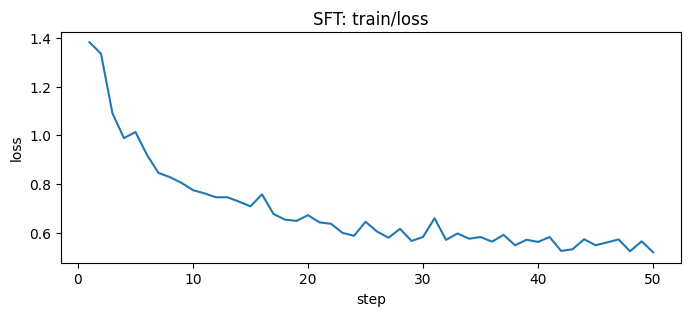

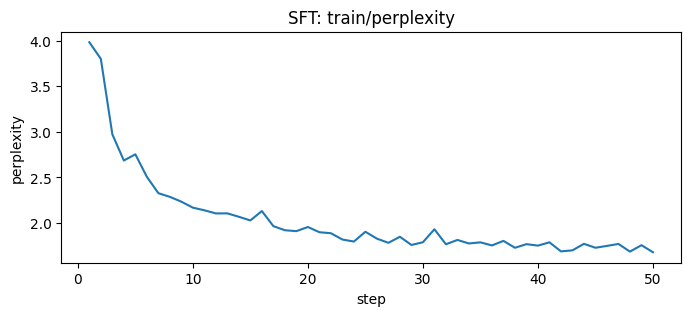


GRPO scalar tags (37):
['actor/eval/kl', 'actor/eval/loss', 'actor/eval/perplexity', 'actor/eval/step_time_sec', 'actor/eval/steps_per_sec', 'actor/train/kl', 'actor/train/loss', 'actor/train/perplexity', 'actor/train/step_time_sec', 'actor/train/steps_per_sec', 'actor/train/tflops_per_step', 'global/eval/completions/max_length', 'global/eval/completions/mean_length', 'global/eval/completions/min_length', 'global/eval/rewards/max', 'global/eval/rewards/min', 'global/eval/rewards/reward_answer', 'global/eval/rewards/reward_format', 'global/eval/rewards/reward_reasoning_quality', 'global/eval/rewards/sum', 'global/train/completions/max_length', 'global/train/completions/mean_length', 'global/train/completions/min_length', 'global/train/rewards/max', 'global/train/rewards/min', 'global/train/rewards/reward_answer', 'global/train/rewards/reward_format', 'global/train/rewards/reward_reasoning_quality', 'global/train/rewards/sum', 'jax/checkpoint/write/blocking_gbytes_per_sec', 'jax/checkpo

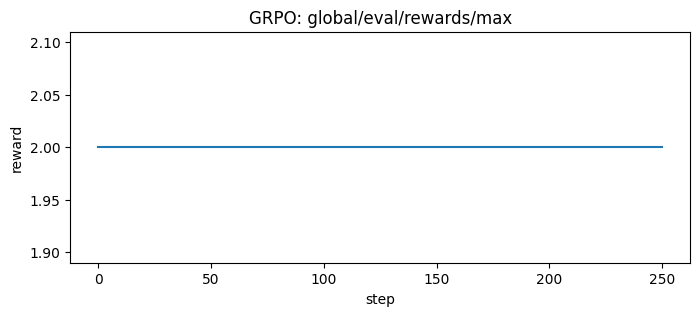

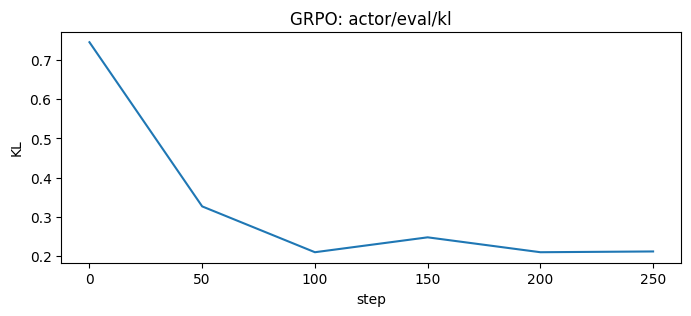

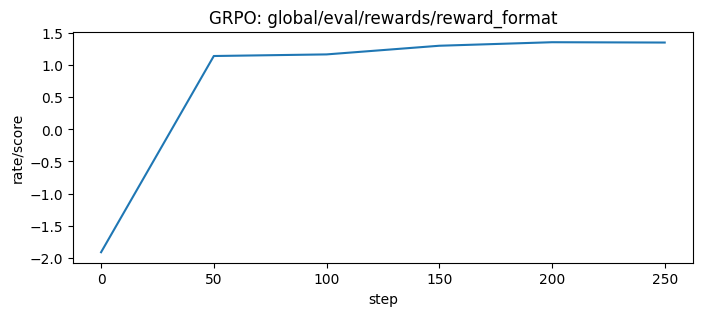

In [37]:
# =========================
# 19.1) Visualization: training curves from TensorBoard event files
#   - SFT loss/perplexity vs step
#   - GRPO reward vs step
#   - KL vs step
# =========================
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _load_scalars(log_dir: Path) -> dict[str, pd.DataFrame]:
    # Uses TensorBoard's event accumulator (works offline)
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    ea = EventAccumulator(str(log_dir))
    ea.Reload()

    out = {}
    tags = ea.Tags().get("scalars", [])
    for tag in tags:
        events = ea.Scalars(tag)
        if not events:
            continue
        out[tag] = pd.DataFrame(
            {"step": [e.step for e in events], "value": [e.value for e in events], "wall_time": [e.wall_time for e in events]}
        )
    return out

def _pick_tag(tags: list[str], include_any: list[str], exclude_any: list[str] | None = None) -> str | None:
    exclude_any = exclude_any or []
    def score(tag: str) -> tuple[int, int]:
        t = tag.lower()
        inc = sum(k in t for k in include_any)
        exc = sum(k in t for k in exclude_any)
        # higher inc, lower exc, shorter tag (tie breaker)
        return (inc - 10*exc, -len(tag))
    candidates = [t for t in tags if any(k in t.lower() for k in include_any)]
    if not candidates:
        return None
    return sorted(candidates, key=score, reverse=True)[0]

def _plot_scalar(df: pd.DataFrame, title: str, y_label: str = "value"):
    plt.figure(figsize=(8, 3))
    plt.plot(df["step"], df["value"])
    plt.title(title)
    plt.xlabel("step")
    plt.ylabel(y_label)
    plt.show()

TB_ROOT = Path(TB_DIR)
sft_dir = TB_ROOT / "sft_seed"
grpo_dir = TB_ROOT / "grpo"

print("TensorBoard dirs:")
print(" - SFT:", sft_dir, "| exists:", sft_dir.exists())
print(" - GRPO:", grpo_dir, "| exists:", grpo_dir.exists())

# -------------------------
# A) SFT curves
# -------------------------
if sft_dir.exists():
    sft_scalars = _load_scalars(sft_dir)
    sft_tags = sorted(sft_scalars.keys())
    print(f"\nSFT scalar tags ({len(sft_tags)}):")
    print(sft_tags[:50], "..." if len(sft_tags) > 50 else "")

    loss_tag = _pick_tag(sft_tags, include_any=["loss"])
    ppl_tag  = _pick_tag(sft_tags, include_any=["perplex", "ppl"])

    if loss_tag:
        _plot_scalar(sft_scalars[loss_tag], f"SFT: {loss_tag}", y_label="loss")
    else:
        print("⚠️ No SFT loss tag found.")

    if ppl_tag:
        _plot_scalar(sft_scalars[ppl_tag], f"SFT: {ppl_tag}", y_label="perplexity")
else:
    print("\n⚠️ SFT logs not found (did you skip SFT or delete logs?).")

# -------------------------
# B) GRPO curves
# -------------------------
if grpo_dir.exists():
    grpo_scalars = _load_scalars(grpo_dir)
    grpo_tags = sorted(grpo_scalars.keys())
    print(f"\nGRPO scalar tags ({len(grpo_tags)}):")
    print(grpo_tags[:60], "..." if len(grpo_tags) > 60 else "")

    # Reward / return
    reward_tag = _pick_tag(grpo_tags, include_any=["reward", "return", "score"])
    kl_tag     = _pick_tag(grpo_tags, include_any=["kl"], exclude_any=["lr"])

    if reward_tag:
        _plot_scalar(grpo_scalars[reward_tag], f"GRPO: {reward_tag}", y_label="reward")
    else:
        print("⚠️ No GRPO reward-like tag found.")

    if kl_tag:
        _plot_scalar(grpo_scalars[kl_tag], f"GRPO: {kl_tag}", y_label="KL")
    else:
        print("⚠️ No GRPO KL tag found.")

    # Optional: format compliance / XML validity if present
    format_tag = _pick_tag(grpo_tags, include_any=["format", "xml", "valid"])
    if format_tag:
        _plot_scalar(grpo_scalars[format_tag], f"GRPO: {format_tag}", y_label="rate/score")

else:
    print("\n⚠️ GRPO logs not found (did you skip GRPO or delete logs?).")


## Inference (load the saved merged model and run predictions)

In [38]:
# =========================
# 20) Inference (HF) — raw vs extracted XML (judge-safe)
# =========================
from pathlib import Path
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

if not export_is_present(INFER_DIR):
    print("⚠️ INFER_DIR not found:", INFER_DIR)
    print("   Run export or set cfg.inference.model_dir to a valid directory.")
else:
    print("Loading tuned inference model from:", INFER_DIR)

    hf_tok = AutoTokenizer.from_pretrained(str(INFER_DIR), local_files_only=True, use_fast=True)
    if hf_tok.pad_token_id is None:
        hf_tok.pad_token = hf_tok.eos_token

    hf_model = AutoModelForCausalLM.from_pretrained(
        str(INFER_DIR),
        local_files_only=True,
        device_map="cpu",
        torch_dtype=torch.float32,
    )
    hf_model.eval()

    # ---------------------------------------------------------------------
    # XML helpers
    # ---------------------------------------------------------------------
    STRICT_XML_FULL_RE = re.compile(
        r"^\s*<reasoning>(?P<reason>.*?)</reasoning>\s*<answer>(?P<ans>.*?)</answer>\s*$",
        re.DOTALL | re.IGNORECASE,
    )
    XML_ANY_RE = re.compile(
        r"<reasoning>(?P<reason>.*?)</reasoning>\s*<answer>(?P<ans>.*?)</answer>",
        re.DOTALL | re.IGNORECASE,
    )
    TAG_RE = re.compile(r"</?(reasoning|answer)>", re.IGNORECASE)

    def is_strict_xml(text: str) -> bool:
        if text is None:
            return False
        m = STRICT_XML_FULL_RE.match(str(text).strip())
        if not m:
            return False
        reason = (m.group("reason") or "")
        ans = (m.group("ans") or "")
        # Disallow nested tags inside fields
        if TAG_RE.search(reason) or TAG_RE.search(ans):
            return False
        return True

    def extract_last_xml_block(text: str) -> str | None:
        """Extract the last <reasoning>...<answer>... block from text (no wrapping)."""
        if text is None:
            return None
        matches = list(XML_ANY_RE.finditer(str(text)))
        if not matches:
            return None
        m = matches[-1]
        reason = (m.group("reason") or "").strip()
        ans = (m.group("ans") or "").strip()
        # Reject nested tags (keeps extraction honest)
        if TAG_RE.search(reason) or TAG_RE.search(ans):
            return None
        return f"<reasoning>{reason}</reasoning>\n<answer>{ans}</answer>"

    def _decode_new_tokens(tok, input_ids, out_ids) -> str:
        prompt_len = int(input_ids.shape[1])
        gen_ids = out_ids[0][prompt_len:]
        return tok.decode(gen_ids, skip_special_tokens=True)

    # ---------------------------------------------------------------------
    # Generation API
    # ---------------------------------------------------------------------
    def generate_one_raw(question: str) -> str:
        """Raw model completion (no post-processing). Use this for strict-format metrics."""
        prompt = build_prompt(question)
        inputs = hf_tok(prompt, return_tensors="pt")
        with torch.no_grad():
            out = hf_model.generate(
                **inputs,
                max_new_tokens=int(INFER_MAX_NEW_TOKENS),
                do_sample=bool(INFER_DO_SAMPLE),
                temperature=float(INFER_TEMPERATURE) if INFER_DO_SAMPLE else None,
                top_p=float(INFER_TOP_P) if INFER_DO_SAMPLE else None,
                top_k=int(INFER_TOP_K) if INFER_DO_SAMPLE else None,
                num_beams=int(INFER_NUM_BEAMS),
                repetition_penalty=float(INFER_REPETITION_PENALTY),
                eos_token_id=hf_tok.eos_token_id,
                pad_token_id=hf_tok.pad_token_id,
            )
        return _decode_new_tokens(hf_tok, inputs["input_ids"], out)

    def generate_one_xml(question: str) -> str:
        """Extracted XML block (for judge-facing display)."""
        raw = generate_one_raw(question)
        xml = extract_last_xml_block(raw)
        return xml if xml is not None else raw

    print("✅ Inference ready.")
    _demo_q = "If a train travels 60 miles in 1.5 hours, what is its speed?"
    _raw = generate_one_raw(_demo_q)
    _xml = generate_one_xml(_demo_q)
    print("\nDEMO (raw completion):\n", _raw)
    print("\nDEMO (extracted XML):\n", _xml)
    print("\nStrict XML valid (raw)?", is_strict_xml(_raw))


Loading tuned inference model from: /kaggle/working/export/google_gemma-3-1b-it_tunix_sft_grpo/merged_lora


`torch_dtype` is deprecated! Use `dtype` instead!


✅ Inference ready.

DEMO (raw completion):
 60 miles / 1.5 hours = 40 miles per hour
<reasoning>The speed of a train is calculated by dividing the distance traveled by the time taken. In this case, the distance is 60 miles and the time is 1.5 hours. Therefore, the speed is 60 miles / 1.5 hours = 40 miles per hour.</reasoning>
<answer>40</answer>
वला昨夜、私は家で過ごし、映画を見ました。とても良い映画でした。
<reasoning>This is a simple sentence expressing a personal experience. It contains a verb ("saw") and a noun ("movie") with a descriptive phrase ("very good").</reasoning>
<answer>40</answer>allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allredwell.allred

DEMO (extracted XML):
 60 miles / 1.5 hours = 40 miles per hour</reasoning>
<answer>40</answer>
ientemente, el razonamiento es que el tiempo que tarda en viajar una distancia es la distancia dividida por la velocidad. Por lo tanto, 

In [ ]:
print('test')

In [39]:
# =========================
# 21) Batch preview (raw + extracted XML + strict-valid flag)
# =========================
import pandas as pd

if not RUN_INFERENCE:
    print("⚠️ RUN_INFERENCE=false — skipping batch preview.")
elif not export_is_present(INFER_DIR):
    print("⚠️ INFER_DIR not found:", INFER_DIR)
elif "generate_one_raw" not in globals():
    print("⚠️ Inference helpers not found. Run the inference cell first.")
else:
    src_df = val_df if (val_df is not None and len(val_df) > 0) else train_df_split
    n = min(int(INFER_MAX_EXAMPLES), int(len(src_df)))
    preview_df = src_df.head(n).copy()

    print(f"Generating {n} examples for a quick qualitative preview...")

    raws = []
    xmls = []
    strict = []
    for q in preview_df[q_col].astype(str).tolist():
        r = generate_one_raw(q)
        x = extract_last_xml_block(r)
        raws.append(r)
        xmls.append(x if x is not None else "")
        strict.append(is_strict_xml(r))

    out_df = pd.DataFrame({
        "question": preview_df[q_col].astype(str).values,
        "raw_completion": raws,
        "xml_extracted": xmls,
        "strict_xml_valid": strict,
    })

    # Write the extracted XML (more notebook-friendly); raw is still in the dataframe above.
    out_df[["question", "xml_extracted", "strict_xml_valid"]].to_csv(INFER_OUTPUT_CSV, index=False)
    print("✅ Wrote:", INFER_OUTPUT_CSV)
    display(out_df.head(10))


Generating 16 examples for a quick qualitative preview...
✅ Wrote: /kaggle/working/predictions.csv


,question,raw_completion,xml_extracted,strict_xml_valid
0,Seth and Max were selling candy bars for a sch...,\n<reasoning>The number of candy bars Max sold...,<reasoning>The problem states that Max sold 24...,False
1,Michael has two brothers. His oldest brother i...,\n<reasoning>The problem states that the oldes...,<reasoning>The problem states that the oldest ...,False
2,Four people in a law firm are planning a party...,12.50</reasoning>\n<answer>Mary's cost is 20 +...,<reasoning>The question asks how much more Mar...,False
3,There are 20 stickers on a page. If you have 1...,12 * 12 - 1 = 144 - 1 = 143</reasoning>\n<answ...,,False
4,Josh built his little brother a rectangular sa...,10</reasoning>\n<answer>The perimeter of a rec...,<reasoning>The perimeter of the sandbox is 30 ...,False
5,"When Spencer jumps rope, he jumps 4 times per ...",20\n<reasoning>The rate at which Spencer jumps...,<reasoning>The problem asks for how many jumps...,False
6,"Zara bought 24 cows, 7 sheep, and some goats. ...",8</reasoning>\n<answer>8</answer>\niede топров...,,False
7,Vanessa has decided to sell some of her clothe...,10\n<reasoning>The total amount Vanessa made i...,<reasoning>The total amount Vanessa made is $6...,False
8,Carl has a goal of selling 96 cupcakes in 2 da...,96 / 2 = 48\nCarl needs to sell 48 cupcakes pe...,,False
9,David has a store where he sells cell phones. ...,14 - 2 - 1 = 11</reasoning>\n<answer>11</answe...,<reasoning>The initial inventory was 14 Samsun...,False


In [ ]:
# =========================
# EVAL) Quick performance check (raw strict XML + numeric accuracy)
# =========================
import re
import pandas as pd

if val_df is None or len(val_df) == 0:
    print("⚠️ val_df not available; skipping quick eval.")
elif "generate_one_raw" not in globals():
    print("⚠️ Inference helpers not available; run the inference cell first.")
else:
    N_EVAL = min(50, len(val_df))
    eval_s = val_df.sample(n=N_EVAL, random_state=int(cfg.data.seed)).copy()

    _NUM_RE = re.compile(r"-?\d+(?:\.\d+)?")

    def _gt_final(raw: str) -> str:
        raw = str(raw)
        if "####" in raw:
            raw = raw.split("####")[-1]
        raw = raw.strip()
        nums = _NUM_RE.findall(raw)
        return nums[-1] if nums else raw

    def _pred_final_from_raw(raw_completion: str) -> str:
        # Only score answers when STRICT XML is satisfied
        if not is_strict_xml(raw_completion):
            return ""
        m = STRICT_XML_FULL_RE.match(str(raw_completion).strip())
        ans = (m.group("ans") or "").strip() if m else ""
        nums = _NUM_RE.findall(ans)
        return nums[-1] if nums else ans

    raws = [generate_one_raw(q) for q in eval_s[q_col].astype(str).tolist()]
    strict = [is_strict_xml(r) for r in raws]
    pred_final = [_pred_final_from_raw(r) for r in raws]

    strict_rate = float(pd.Series(strict).mean())

    if a_col is not None and a_col in eval_s.columns:
        gt_final = eval_s[a_col].map(_gt_final).astype(str).tolist()
        # Overall accuracy (invalid format counts as wrong)
        acc_overall = float((pd.Series(pred_final) == pd.Series(gt_final)).mean())
        # Accuracy on strict-only subset
        strict_mask = pd.Series(strict)
        if strict_mask.any():
            acc_strict_only = float((pd.Series(pred_final)[strict_mask] == pd.Series(gt_final)[strict_mask]).mean())
        else:
            acc_strict_only = float("nan")
    else:
        gt_final = [""] * N_EVAL
        acc_overall = float("nan")
        acc_strict_only = float("nan")

    # Reasoning length proxy (strict-only)
    def _reason_words(raw_completion: str) -> int:
        if not is_strict_xml(raw_completion):
            return 0
        m = STRICT_XML_FULL_RE.match(str(raw_completion).strip())
        return len((m.group("reason") or "").strip().split()) if m else 0

    mean_reason_words = float(pd.Series([_reason_words(r) for r in raws]).replace(0, pd.NA).dropna().mean()) if any(strict) else 0.0

    print(f"Quick eval on N={N_EVAL} examples:")
    print("  Strict XML valid rate:", strict_rate)
    if any(strict):
        print("  Mean reasoning words (strict-only):", mean_reason_words)
    if a_col is not None and a_col in eval_s.columns:
        print("  Numeric accuracy (overall):", acc_overall)
        print("  Numeric accuracy (strict-only):", acc_strict_only)
    else:
        print("  Numeric accuracy: skipped (a_col missing)")

    preview = pd.DataFrame({
        "question": eval_s[q_col].astype(str).values,
        "gt_final": gt_final,
        "pred_final": pred_final,
        "strict_xml_valid": strict,
        "raw_completion": raws,
    }).head(10)

    display(preview)


In [ ]:
# =========================
# 22) Qualitative before/after (base vs tuned) — strict-valid comparison
# =========================
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

if "generate_one_raw" not in globals():
    print("⚠️ Inference helpers not available; run the inference cell first.")
else:
    # Pick a small, reproducible sample
    if val_df is None or len(val_df) == 0:
        print("⚠️ val_df not available; using a sample from train_df_split.")
        sample_df = train_df_split.sample(n=min(8, len(train_df_split)), random_state=int(cfg.data.seed))
    else:
        sample_df = val_df.sample(n=min(8, len(val_df)), random_state=int(cfg.data.seed))

    # Load base model for comparison
    print("Loading base model for comparison:", MODEL_ID)
    base_tok = AutoTokenizer.from_pretrained(MODEL_ID)
    if base_tok.pad_token_id is None:
        base_tok.pad_token = base_tok.eos_token
    base_model_hf = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map="cpu", torch_dtype=torch.float32)
    base_model_hf.eval()

    def _decode_new_tokens(tok, input_ids, out_ids) -> str:
        prompt_len = int(input_ids.shape[1])
        gen_ids = out_ids[0][prompt_len:]
        return tok.decode(gen_ids, skip_special_tokens=True)

    def gen_base_raw(question: str) -> str:
        prompt = build_prompt(question)
        inputs = base_tok(prompt, return_tensors="pt")
        with torch.no_grad():
            out = base_model_hf.generate(
                **inputs,
                max_new_tokens=int(INFER_MAX_NEW_TOKENS),
                do_sample=bool(INFER_DO_SAMPLE),
                temperature=float(INFER_TEMPERATURE) if INFER_DO_SAMPLE else None,
                top_p=float(INFER_TOP_P) if INFER_DO_SAMPLE else None,
                top_k=int(INFER_TOP_K) if INFER_DO_SAMPLE else None,
                num_beams=int(INFER_NUM_BEAMS),
                repetition_penalty=float(INFER_REPETITION_PENALTY),
                eos_token_id=base_tok.eos_token_id,
                pad_token_id=base_tok.pad_token_id,
            )
        return _decode_new_tokens(base_tok, inputs["input_ids"], out)

    def _reason_words_if_strict(raw: str) -> int:
        if not is_strict_xml(raw):
            return 0
        m = STRICT_XML_FULL_RE.match(str(raw).strip())
        return len((m.group("reason") or "").strip().split()) if m else 0

    def _answer_if_strict(raw: str) -> str:
        if not is_strict_xml(raw):
            return ""
        m = STRICT_XML_FULL_RE.match(str(raw).strip())
        return (m.group("ans") or "").strip() if m else ""

    rows = []
    for q in sample_df[q_col].astype(str).tolist():
        base_raw = gen_base_raw(q)
        tuned_raw = generate_one_raw(q)

        rows.append({
            "question": (q[:120] + "…") if len(q) > 120 else q,
            "base_xml_valid": is_strict_xml(base_raw),
            "tuned_xml_valid": is_strict_xml(tuned_raw),
            "base_reason_words": _reason_words_if_strict(base_raw),
            "tuned_reason_words": _reason_words_if_strict(tuned_raw),
            "base_answer": _answer_if_strict(base_raw),
            "tuned_answer": _answer_if_strict(tuned_raw),
        })

    df_qual = pd.DataFrame(rows)
    display(df_qual)

    print("\nStrict XML valid rate:")
    print("  base :", float(df_qual['base_xml_valid'].mean()))
    print("  tuned:", float(df_qual['tuned_xml_valid'].mean()))

    # Optional: show the raw completions for a single example (debug)
    if len(sample_df) > 0:
        _q0 = sample_df[q_col].astype(str).iloc[0]
        print("\n--- Debug: first example raw completions ---")
        print("Q:", _q0)
        print("\nBASE RAW:\n", gen_base_raw(_q0))
        print("\nTUNED RAW:\n", generate_one_raw(_q0))


In [ ]:
# =========================
# VIZ) Judge-friendly qualitative comparison plots (df_qual)
# =========================
import matplotlib.pyplot as plt
import pandas as pd

if "df_qual" not in globals() or df_qual is None or len(df_qual) == 0:
    print("⚠️ df_qual not found. Run the qualitative before/after cell first.")
else:
    # 1) XML validity rate
    rates = pd.Series({
        "base": float(df_qual["base_xml_valid"].mean()),
        "tuned": float(df_qual["tuned_xml_valid"].mean()),
    })
    ax = rates.plot(kind="bar", ylim=(0, 1), rot=0, title="XML validity rate (base vs tuned)")
    ax.set_ylabel("fraction valid")
    plt.show()

    # 2) Reasoning depth (word count)
    ax = df_qual[["base_reason_words", "tuned_reason_words"]].plot(
        kind="box",
        title="Reasoning depth proxy (word count) — base vs tuned",
    )
    ax.set_ylabel("words in <reasoning>")
    plt.show()

    # 3) Quick table view (sorted)
    display(df_qual.sort_values(["tuned_xml_valid", "tuned_reason_words"], ascending=[False, False]).reset_index(drop=True))


## Troubleshooting and practical tips

Common issues and the most effective fixes:

- **GRPO seems “stuck” at the beginning**  
  The first step includes XLA compilation for multiple graphs (rollout + log-prob computation). Reduce:
  - `grpo.max_prompt_length`
  - `grpo.total_generation_steps`
  - `grpo.num_generations`
  - `grpo.train_micro_batch_size`

- **HBM OOM during reference log-prob computation**  
  Set:
  - `grpo.compute_logps_micro_batch_pref: 1`
  - `grpo.offload_to_cpu: true` (slower, but reduces TPU HBM usage)

- **You do not want to retrain**  
  If `export/<run_name>/<merged_subdir>/` exists, keep:
  - `runtime.skip_training_if_export_exists: true`  
  and simply run the **Inference** section.

- **Want to force a new run**  
  Set:
  - `runtime.force_retrain: true`


## Submission helper (required for unrestricted mode)

If you want the **optional +15 pts** in *unrestricted / multi-session mode*, you must provide a **Kaggle Model ID** that the judges can load.

Set it in `config.yaml`:

```yaml
submission:
  mode: unrestricted
  unrestricted_kaggle_model_id: "<your-username>/<your-model>"
```

This notebook will print the value below so it’s easy to verify.


In [ ]:
# =========================
# Submission fields (unrestricted mode)
# =========================
unrestricted_kaggle_model = (cfg.submission.unrestricted_kaggle_model_id or "").strip()
print("submission.mode:", cfg.submission.mode)
print("unrestricted_kaggle_model:", unrestricted_kaggle_model if unrestricted_kaggle_model else "(not set)")

print("\nPaths:")
print("CKPT_DIR :", CKPT_DIR)
print("INFER_DIR:", INFER_DIR)
